# ols_results_delay

In [4]:
# General
import sys
import os.path as op
import copy
from time import time
from collections import OrderedDict as od
from glob import glob
import itertools
import warnings
from importlib import reload
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.utils.fixes import loguniform
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import patsy

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
# from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from helper_funcs import *
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, remapping, pop_decoding, time_cell_plots
from goldmine_replay import place_cells

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

data_dir = '/data7/goldmine'
proj_dir = '/home1/dscho/projects/time_cells'

In [5]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(data_dir, 'analysis', 'events', '*-Events.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [3]:
def run_ols_delay_parallel(subj_sess_unit):
    import sys
    import os
    sys.path.append('/home1/dscho/code/projects')
    from time_cells import time_bin_analysis
    
    proj_dir = '/home1/dscho/projects/time_cells'
    n_perm = 10000
    
    try:
        mod_pairs, ols_weights = time_bin_analysis.run_ols_delay(subj_sess_unit,
                                                                 n_perm=1000,
                                                                 alpha=0.05,
                                                                 save_output=True,
                                                                 overwrite=False)
    except:
        err = sys.exc_info()
        errf = '/home1/dscho/logs/TryExceptError-run_ols_delay_parallel-{}'.format(subj_sess_unit)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')

In [ ]:
# Get neurons to process.
fpath = op.join(proj_dir, 'analysis', 'unit_to_behav_10k', '{}-Delay1_Delay2-ols_model_pairs.pkl')
pop_spikes = pop_decoding.load_pop_spikes()
neurons = [neuron for neuron in pop_spikes.neurons if not op.exists(fpath.format(neuron))]
print('{} neurons to process'.format(len(neurons)))

# Parallel processing
n_ops = len(neurons)
print('Running code for {} operations.\n'.format(n_ops))
with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=np.min((n_ops, 100)), cores_per_job=1) as view:
    output = view.map(run_ols_delay_parallel, neurons)

457 neurons to process
Running code for 457 operations.

66 Engines running


In [3]:
subj_sess_unit = 'U532_ses0-21-1' # 'U527_ses0-58-2' # 'U518_ses0-73-1'

start_time = time()

mod_pairs, ols_weights = time_bin_analysis.run_ols_delay(subj_sess_unit)

print('Done in {:.1f}s'.format(time() - start_time))

Done in 126.2s


# Load mod_pairs, ols_weights

In [6]:
# Load processed OLS files.
mod_pairs_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Delay1_Delay2-ols_model_pairs.pkl')
ols_weights_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Delay1_Delay2-ols_weights.pkl')
mod_pairs = pd.concat([dio.open_pickle(f) for f in glob(mod_pairs_globstr)]).reset_index(drop=True)
ols_weights = pd.concat([dio.open_pickle(f) for f in glob(ols_weights_globstr)]).reset_index(drop=True)

# Drop rows.
drop_red = ['full-time,gameState:time']
mod_pairs = mod_pairs.query("(red!={})".format(drop_red)).reset_index(drop=True)

# Add columns.
_map = {'full-gameState': 'gameState',
        'full-time': 'time',
        'full-gameState:time': 'gameState:time'}
testvar_cat = pd.CategoricalDtype(['gameState', 'time', 'gameState:time'],
                                  ordered=True)
mod_pairs.insert(4, 'testvar', mod_pairs['red'].apply(lambda x: _map[x]))
mod_pairs['testvar'] = mod_pairs['testvar'].astype(testvar_cat)

print('mod_pairs: {}'.format(mod_pairs.shape))
print('ols_weights: {}'.format(ols_weights.shape))

mod_pairs: (1371, 14)
ols_weights: (10054, 9)


In [7]:
# FDR correct across all neurons.
alpha = 0.05
sig_col = 'sig'

mod_pairs['sig01'] = ''
mod_pairs['sig_fdr'] = ''
for testvar in mod_pairs['testvar'].unique():
    pvals = mod_pairs.loc[mod_pairs['testvar']==testvar, 'emp_pval']
    sig_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[0]
    pvals_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[1]
    
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'sig01'] = pvals < 0.01
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'pvals_fdr'] = pvals_fdr
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'sig_fdr'] = sig_fdr

sig_cells = od([])
for testvar in mod_pairs['testvar'].unique():
    sig_cells[testvar] = mod_pairs.query("(testvar=='{}') & ({}==True)".format(testvar, sig_col))['subj_sess_unit'].tolist()

In [8]:
testvars = ['gameState', 'time', 'gameState:time']

count_sig = od([])
count_all = od([])
n_cells = mod_pairs['subj_sess_unit'].unique().size
pvals_unc = od([])
for testvar in testvars:
    n_sig = len(sig_cells[testvar])
    binom_p = stats.binom_test(n_sig,
                               n_cells,
                               p=0.05,
                               alternative='greater')
    count_sig[testvar] = n_sig
    count_all[testvar] = n_cells
    pvals_unc[testvar] = binom_p

# Bonferroni-Holm correct
pvals_corr = sm.stats.multipletests(list(pvals_unc.values()), method='holm')[1]

for iTest, testvar in enumerate(pvals_unc):
    print('{:>19}'.format(testvar),
          '{:>3}/{:>3} {:>6.1%} '.format(count_sig[testvar], count_all[testvar], (1. * count_sig[testvar]) / count_all[testvar]),
          '{:.10f}{:>1}'.format(pvals_unc[testvar], '*' if (pvals_unc[testvar] < alpha) else ''),
          '{:.10f}{:>1}'.format(pvals_corr[iTest], '*' if (pvals_corr[iTest] < alpha) else ''))

          gameState  70/457  15.3%  0.0000000000* 0.0000000000*
               time  99/457  21.7%  0.0000000000* 0.0000000000*
     gameState:time  26/457   5.7%  0.2774196574  0.2774196574 


In [7]:
# How many time cells per subject?
aop.unique([x.split('_')[0] for x in sig_cells['time']])

U518    25
U532    23
U536    19
U530    13
U540     6
U527     4
U537     4
U539     2
U521     2
U526     1
dtype: int64

In [8]:
# How many delay category cells per subject?
aop.unique([x.split('_')[0] for x in sig_cells['gameState']])

U532    18
U527    17
U530    10
U518     6
U536     6
U526     5
U540     3
U539     3
U537     1
U521     1
dtype: int64

In [9]:
mod_pairs.groupby('testvar', observed=True).agg({'sig': count_pct,
                                                 'sig01': count_pct,
                                                 'sig_fdr': count_pct})

,sig,sig01,sig_fdr
testvar,,,
gameState,70/457 (15.3%),27/457 (5.9%),12/457 (2.6%)
time,99/457 (21.7%),51/457 (11.2%),33/457 (7.2%)
gameState:time,26/457 (5.7%),3/457 (0.7%),0/457 (0.0%)


In [10]:
(mod_pairs.query("(sig==True)")
          .groupby('testvar', observed=True)
          .agg({'subj_sess_unit': len,
                'z_lr': [mean_sem, median_q]}))

subj_sess_unit         z_lr                   
                          len     mean_sem           median_q
testvar                                                      
gameState                  70  4.77 ± 0.40  3.49 (2.64, 5.49)
time                       99  4.15 ± 0.36  2.98 (2.24, 4.49)
gameState:time             26  2.48 ± 0.10  2.27 (2.15, 2.70)

39/70 (55.7%) neurons with a main effect of delay category fire more in Delay1 than Delay2 (p = 0.402963, binomial test)


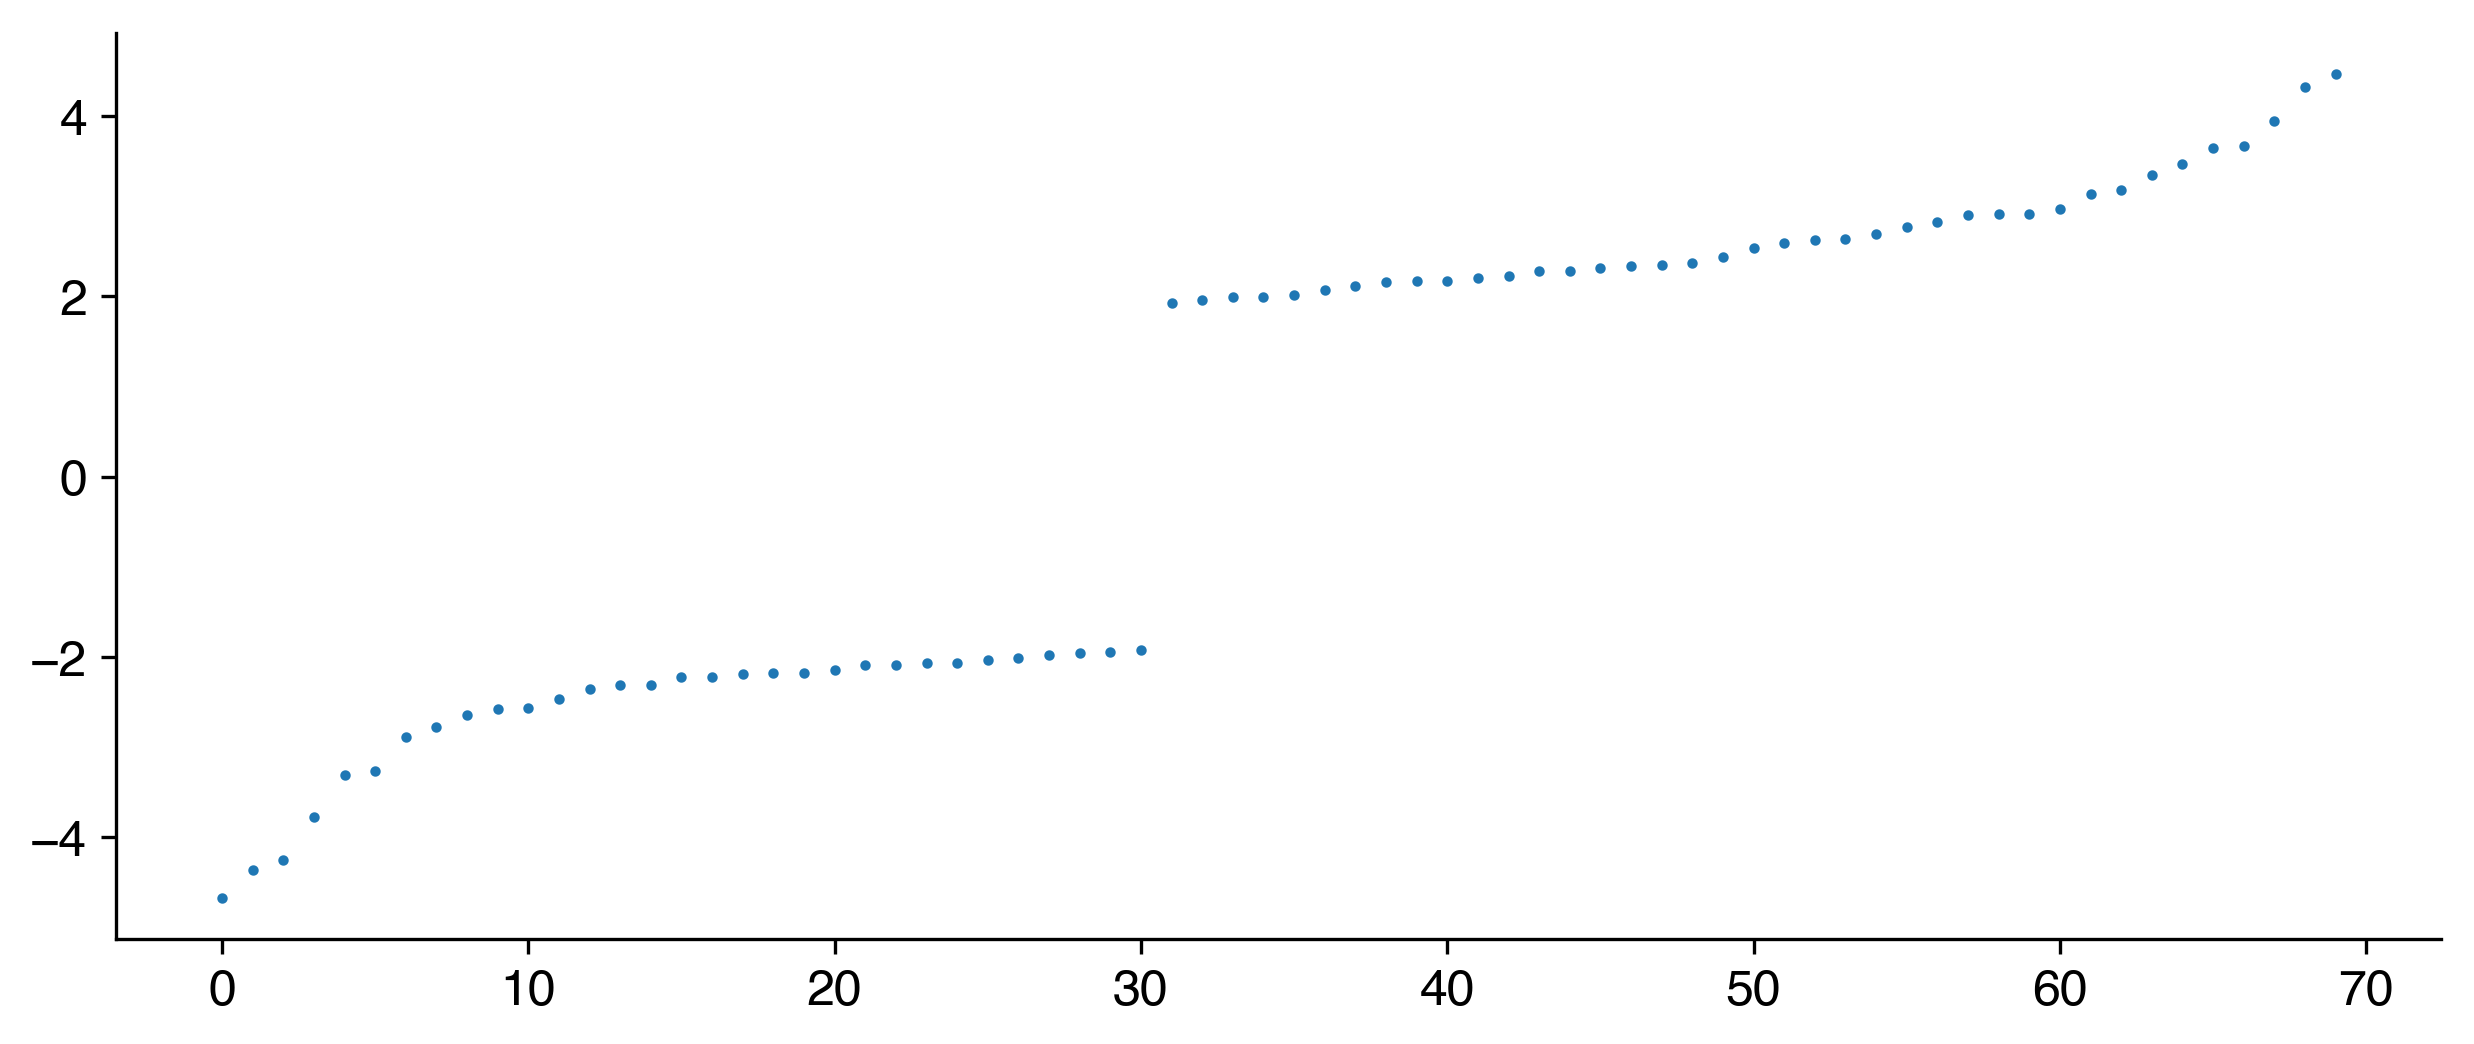

In [20]:
_df = (ols_weights.query("(subj_sess_unit=={}) & (factor=='gameState')".format(sig_cells['gameState']))
                  .groupby("subj_sess_unit")['z_weight']
                  .apply(lambda x: 1 * x))
print(count_pct(_df>0) + ' neurons with a main effect of delay category fire more in Delay1 than Delay2', 
      '(p = {:.6f}, binomial test)'.format(stats.binom_test(np.count_nonzero(_df>0), len(_df), 0.5)))
plt.plot(_df.sort_values().values, marker='.', linewidth=0)

In [23]:
mod_name = 'full'
factor = 'time'
weight_col = 'z_weight'

qry = "(subj_sess_unit=={}) & (model=='{}') & (factor=='{}')"
levels = ols_weights.query(qry.format(sig_cells[factor], mod_name, factor))['level'].drop_duplicates().values

_df = (ols_weights.query(qry.format(sig_cells[factor], mod_name, factor))
                  .groupby(['subj_sess_unit', 'model', 'factor'], sort=False)
                  .agg({weight_col: [lambda x: levels[np.argmax(np.abs(x))], lambda x: np.array(x)[np.argmax(np.abs(x))]]})
                  .reset_index())
_df.columns = ['subj_sess_unit', 'model', 'factor', 'level', weight_col]
_df['level'] = _df['level'].astype(pd.CategoricalDtype(levels, ordered=True)) 

print('{} – {}; P = {:.6f}, binomial test'.format(factor,
                                                  count_pct(_df[weight_col]>0),
                                                  stats.binom_test(np.count_nonzero(_df[weight_col]>0), len(_df), 0.5)),
      end='\n'*2)
(_df.groupby('level', observed=False)
    .agg({'subj_sess_unit' : lambda x: '{:>2}/{:>2} ({:.1%})'.format(len(x), len(_df), len(x)/len(_df)),
          weight_col       : [lambda x: mean_sem(np.abs(x)), lambda x: count_pct(x>0)]}))

time – 72/99 (72.7%); P = 0.000007, binomial test



subj_sess_unit     z_weight               
              <lambda>   <lambda_0>     <lambda_1>
level                                             
time_1   39/99 (39.4%)  4.12 ± 0.25  29/39 (74.4%)
time_2   23/99 (23.2%)  3.28 ± 0.15  17/23 (73.9%)
time_3     5/99 (5.1%)  2.55 ± 0.17    4/5 (80.0%)
time_4     8/99 (8.1%)  2.72 ± 0.16    6/8 (75.0%)
time_5     4/99 (4.0%)  2.87 ± 0.10    3/4 (75.0%)
time_6            None         None           None
time_7     5/99 (5.1%)  2.63 ± 0.20    4/5 (80.0%)
time_8     2/99 (2.0%)  3.04 ± 0.80    1/2 (50.0%)
time_9     7/99 (7.1%)  2.76 ± 0.15    3/7 (42.9%)
time_10    6/99 (6.1%)  3.29 ± 0.23    5/6 (83.3%)

In [33]:
# Are time cells over-represented in each third of the delay?
x = [67, 17, 15]
bins = [3, 4, 3]
n = 457
alpha = 0.05

pvals = [stats.binom_test(x[i], n, 0.05 * (bins[i]/10)) for i in range(len(x))]
pvals_corr = sm.stats.multipletests(pvals, alpha, method='holm')[1]

print(pvals, pvals_corr, pvals_corr<alpha)

[5.237298572688282e-44, 0.017148305917944025, 0.0054384118884365975] [1.57118957e-43 1.71483059e-02 1.08768238e-02] [ True  True  True]


In [42]:
factors = ['icpt', 'gameState', 'time', 'gameState:time']
ols_weights['factor'] = ols_weights['factor'].astype(pd.CategoricalDtype(factors, ordered=True))

levels = ['icpt', 'gameState_Delay1'] + ['time_{}'.format(iTime) for iTime in range(1, 11)] + ['gameState_Delay1:time_{}'.format(iTime) for iTime in range(1, 11)]
ols_weights['level'] = ols_weights['level'].astype(pd.CategoricalDtype(levels, ordered=True))

In [69]:
def _merge_dfs():
    level = 'level-{}'.format(factor)
    level_weight = level + '-z_weight'
    if level in mod_pairs:
        mod_pairs.drop(columns=level, inplace=True)
    if level_weight in mod_pairs:
        mod_pairs.drop(columns=level_weight, inplace=True)
        
    return (pd.merge(mod_pairs, _df.rename(columns={'model': 'full', 'factor': 'testvar'}),
                     on=['subj_sess_unit', 'full', 'testvar'], how='left')
            .rename(columns={'level': level, 'z_weight': level_weight}))

# How many cells preferentially encode each level
# of a given variable of interest?
mod_name = 'full'
factor = 'time'
merge_mod_pairs = True

qry = "(subj_sess_unit=={}) & (model=='{}') & (factor=='{}')"
levels = ols_weights.query(qry.format(sig_cells[factor], mod_name, factor))['level'].drop_duplicates().values

_df = (ols_weights.query(qry.format(sig_cells[factor], mod_name, factor))
                  .groupby(['subj_sess_unit', 'model', 'factor'], sort=False, observed=True)
                  .agg({'z_weight': [lambda x: levels[np.argmax(np.abs(x))], lambda x: np.array(x)[np.argmax(np.abs(x))]]})
                  .reset_index())
_df.columns = ['subj_sess_unit', 'model', 'factor', 'level', 'z_weight']
_df['level'] = _df['level'].astype(pd.CategoricalDtype(levels, ordered=True))
if merge_mod_pairs:
    mod_pairs = _merge_dfs()
    
print('{} – {}; P = {:.6f}, binomial test'.format(factor,
                                                  count_pct(_df['z_weight']>0),
                                                  stats.binom_test(np.count_nonzero(_df['z_weight']>0), len(_df), 0.5)),
      end='\n'*2)
(_df.groupby('level', observed=True)
    .agg({'subj_sess_unit' : lambda x: '{:>2}/{:>2} ({:.1%})'.format(len(x), len(_df), len(x)/len(_df)),
          'z_weight'       : [lambda x: mean_sem(np.abs(x)), lambda x: count_pct(x>0)]}))

time – 72/99 (72.7%); P = 0.000007, binomial test



subj_sess_unit     z_weight               
              <lambda>   <lambda_0>     <lambda_1>
level                                             
time_1   39/99 (39.4%)  4.12 ± 0.25  29/39 (74.4%)
time_2   23/99 (23.2%)  3.28 ± 0.15  17/23 (73.9%)
time_3     5/99 (5.1%)  2.55 ± 0.17    4/5 (80.0%)
time_4     8/99 (8.1%)  2.72 ± 0.16    6/8 (75.0%)
time_5     4/99 (4.0%)  2.87 ± 0.10    3/4 (75.0%)
time_7     5/99 (5.1%)  2.63 ± 0.20    4/5 (80.0%)
time_8     2/99 (2.0%)  3.04 ± 0.80    1/2 (50.0%)
time_9     7/99 (7.1%)  2.76 ± 0.15    3/7 (42.9%)
time_10    6/99 (6.1%)  3.29 ± 0.23    5/6 (83.3%)

In [71]:
mod_pairs.query("(full=='full') & (testvar=='time') & (sig==True)").sort_values('z_lr', ascending=0).iloc[:30]

,subj_sess_unit,hem,roi,gameState,testvar,full,red,llf_full,llf_red,df,lr,z_lr,emp_pval,sig,sig01,sig_fdr,pvals_fdr,level-time,level-time-z_weight
232,U518_ses0-73-1,L,TPO,Delay1-Delay2,time,full,full-time,-1943.168757,-2002.548294,9,118.759074,28.724355,0.000999,True,True,True,0.017790,time_1,10.023375
1174,U537_ses0-24-1,R,AH,Delay1-Delay2,time,full,full-time,-1236.900812,-1271.732523,9,69.663424,15.687520,0.000999,True,True,True,0.017790,time_1,7.090101
127,U518_ses0-4-1,R,EC,Delay1-Delay2,time,full,full-time,-2023.200054,-2055.194295,9,63.988482,13.821309,0.000999,True,True,True,0.017790,time_1,7.849135
166,U518_ses1-4-1,R,EC,Delay1-Delay2,time,full,full-time,-1952.206486,-1981.875146,9,59.337320,13.064955,0.000999,True,True,True,0.017790,time_1,7.032121
883,U532_ses0-10-1,R,A,Delay1-Delay2,time,full,full-time,-1794.206468,-1815.578353,9,42.743770,9.397007,0.000999,True,True,True,0.017790,time_1,-4.169225
274,U518_ses0-40-1,L,MH,Delay1-Delay2,time,full,full-time,-2002.848480,-2025.523679,9,45.350398,9.053304,0.000999,True,True,True,0.017790,time_1,5.081984
898,U532_ses0-20-1,R,FSG,Delay1-Delay2,time,full,full-time,-1701.863809,-1722.948374,9,42.169130,8.913498,0.000999,True,True,True,0.017790,time_2,4.657655
121,U518_ses0-16-2,R,TO,Delay1-Delay2,time,full,full-time,-1533.214358,-1555.128417,9,43.828118,8.798398,0.000999,True,True,True,0.017790,time_2,5.111433
1039,U536_ses0-31-2,L,AC,Delay1-Delay2,time,full,full-time,-900.111078,-921.549625,9,42.877095,8.292077,0.000999,True,True,True,0.017790,time_1,6.078630
1303,U539_ses0-55-1,L,EC,Delay1-Delay2,time,full,full-time,-1461.094467,-1478.699568,9,35.210202,7.584221,0.000999,True,True,True,0.017790,time_1,4.172285


In [75]:
subj_sess_unit = 'U532_ses0-10-1'

display(mod_pairs.query("(subj_sess_unit=='{}')".format(subj_sess_unit)))
display(ols_weights.query("(model=='full') & (subj_sess_unit=='{}')".format(subj_sess_unit))
                   .sort_values(['factor', 'level'], ascending=[True, True]))

,subj_sess_unit,hem,roi,gameState,testvar,full,red,llf_full,llf_red,df,lr,z_lr,emp_pval,sig,sig01,sig_fdr,pvals_fdr,level-time,level-time-z_weight
882,U532_ses0-10-1,R,A,Delay1-Delay2,gameState,full,full-gameState,-1794.206468,-1796.473957,1,4.534978,0.523793,0.186813,False,False,False,0.581963,NaN,NaN
883,U532_ses0-10-1,R,A,Delay1-Delay2,time,full,full-time,-1794.206468,-1815.578353,9,42.743770,9.397007,0.000999,True,True,True,0.017790,time_1,-4.169225
884,U532_ses0-10-1,R,A,Delay1-Delay2,gameState:time,full,full-gameState:time,-1794.206468,-1798.634132,9,8.855328,0.341595,0.314685,False,False,False,0.916194,NaN,NaN


,subj_sess_unit,hem,roi,gameState,model,factor,level,weight,z_weight
6468,U532_ses0-10-1,R,A,Delay1-Delay2,full,icpt,icpt,8.356061,0.000000
6469,U532_ses0-10-1,R,A,Delay1-Delay2,full,gameState,gameState_Delay1,0.304545,1.258434
6470,U532_ses0-10-1,R,A,Delay1-Delay2,full,time,time_1,-1.719697,-4.169225
6471,U532_ses0-10-1,R,A,Delay1-Delay2,full,time,time_2,-1.492424,-3.628453
6472,U532_ses0-10-1,R,A,Delay1-Delay2,full,time,time_3,-0.537879,-1.360537
6473,U532_ses0-10-1,R,A,Delay1-Delay2,full,time,time_4,-0.007576,-0.001681
6474,U532_ses0-10-1,R,A,Delay1-Delay2,full,time,time_5,-0.159091,-0.351058
6475,U532_ses0-10-1,R,A,Delay1-Delay2,full,time,time_6,0.946970,2.428222
6476,U532_ses0-10-1,R,A,Delay1-Delay2,full,time,time_7,0.659091,1.556755
6477,U532_ses0-10-1,R,A,Delay1-Delay2,full,time,time_8,0.719697,1.861636


# Time fields

In [8]:
reload(time_bin_analysis)

<module 'time_cells.time_bin_analysis' from '/home1/dscho/code/projects/time_cells/time_bin_analysis.py'>

In [7]:
# Find time fields for all significant gameState:time cells.
save_output = 1
overwrite = 0
verbose = False
smooth = 1
n_perm = 1000
thresh = 1.96
max_skips = 1

start_time = time()

for subj_sess_unit in sig_cells['time']:
    output = time_bin_analysis.bootstrap_time_fields(subj_sess_unit,
                                                     game_states=['Delay1', 'Delay2'],
                                                     smooth=smooth,
                                                     n_perm=n_perm,
                                                     thresh=thresh,
                                                     max_skips=max_skips,
                                                     save_output=save_output,
                                                     overwrite=overwrite,
                                                     verbose=verbose)
    
print('Done in {:.1f}s'.format(time() - start_time))

Done in 1211.7s


In [356]:
# Load time field results.
files = glob(op.join(proj_dir, 'analysis', 'time_fields', '*Delay1_Delay2-smooth1*.pkl'))
# files = glob(op.join(proj_dir, 'analysis', 'time_fields', '*Delay1_Delay2-smooth0*.pkl'))

time_fields = pd.concat([dio.open_pickle(f)['time_fields'] for f in files]).reset_index(drop=True)

print('time_fields:', time_fields.shape)

time_fields: (507, 8)


In [357]:
time_fields.query("(gameState=='Delay1Delay2')").shape

(206, 8)

In [328]:
print('{} time cells with a time_field'.format(count_pct(np.isin(sig_cells['time'],
          time_fields.query("(gameState=='Delay1Delay2')")['subj_sess_unit'].unique()))),
      '{} time cells with a positive time_field'.format(count_pct(np.isin(sig_cells['time'],
          time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['subj_sess_unit'].unique()))),
      '{} time cells with a negative time_field'.format(count_pct(np.isin(sig_cells['time'],
          time_fields.query("(gameState=='Delay1Delay2') & (field_type=='neg')")['subj_sess_unit'].unique()))),
      sep='\n')

99/99 (100.0%) time cells with a time_field
93/99 (93.9%) time cells with a positive time_field
88/99 (88.9%) time cells with a negative time_field


In [329]:
subj_sess_unit = 'U518_ses0-16-1'

mod_pairs.query("(subj_sess_unit=='{}')".format(subj_sess_unit))

,subj_sess_unit,hem,roi,gameState,testvar,full,red,llf_full,llf_red,df,lr,z_lr,emp_pval,sig,sig01,sig_fdr,pvals_fdr,level-time,level-time-z_weight
186,U518_ses0-16-1,R,TO,Delay1-Delay2,gameState,full,full-gameState,-1872.154562,-1872.189158,1,0.069192,-0.650672,0.831169,False,False,False,0.985695,NaN,NaN
187,U518_ses0-16-1,R,TO,Delay1-Delay2,time,full,full-time,-1872.154562,-1886.985561,9,29.661997,5.015794,0.000999,True,True,True,0.017790,time_1,-2.97863
188,U518_ses0-16-1,R,TO,Delay1-Delay2,gameState:time,full,full-gameState:time,-1872.154562,-1874.565122,9,4.821120,-0.907100,0.802198,False,False,False,0.991759,NaN,NaN


In [330]:
subj_sess_unit = 'U518_ses0-16-1'

time_fields.query("(subj_sess_unit=='{}')".format(subj_sess_unit))

,subj_sess_unit,gameState,field_type,field_peak,peak_z,mean_z,field_size,field_idx
0,U518_ses0-16-1,Delay1,pos,4,2.752321,2.486295,4,"[3, 4, 5, 6]"
1,U518_ses0-16-1,Delay1,neg,0,-3.193988,-3.193988,1,[0]
2,U518_ses0-16-1,Delay1,neg,16,-2.005406,-2.005406,1,[16]
3,U518_ses0-16-1,Delay2,neg,0,-2.864775,-2.864775,1,[0]
4,U518_ses0-16-1,Delay1Delay2,pos,4,3.318756,2.883617,3,"[3, 4, 5]"
5,U518_ses0-16-1,Delay1Delay2,pos,8,2.234359,2.234359,1,[8]
6,U518_ses0-16-1,Delay1Delay2,neg,0,-4.193840,-4.193840,1,[0]
7,U518_ses0-16-1,Delay1Delay2,neg,16,-2.120274,-2.120274,1,[16]


In [301]:
(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")
            .groupby('subj_sess_unit')
            .agg({'peak_z': np.max,
                  'field_peak': list,
                  'field_size': list})
            .sort_values('peak_z'))

,peak_z,field_peak,field_size
subj_sess_unit,,,
U521_ses0-19-1,2.071778,"[7, 13]","[2, 1]"
U518_ses0-78-1,2.174923,[14],[2]
U540_ses0-11-1,2.177576,[0],[1]
U532_ses0-8-1,2.208118,"[12, 17]","[1, 1]"
U518_ses0-4-2,2.274200,[8],[2]
U530_ses1-71-1,2.292562,[14],[1]
U536_ses0-22-1,2.334609,"[0, 5]","[1, 1]"
U532_ses0-21-2,2.356589,[17],[1]
U518_ses0-13-2,2.383723,[2],[4]


,field_size,0
0,1,5
1,2,24
2,3,26
3,4,16
4,5,8
5,6,1
6,8,1


1.13 ± 0.03 time fields/neuron
1.00 (1.00, 1.00) time fields/neuron
81 neurons have only 1 time field


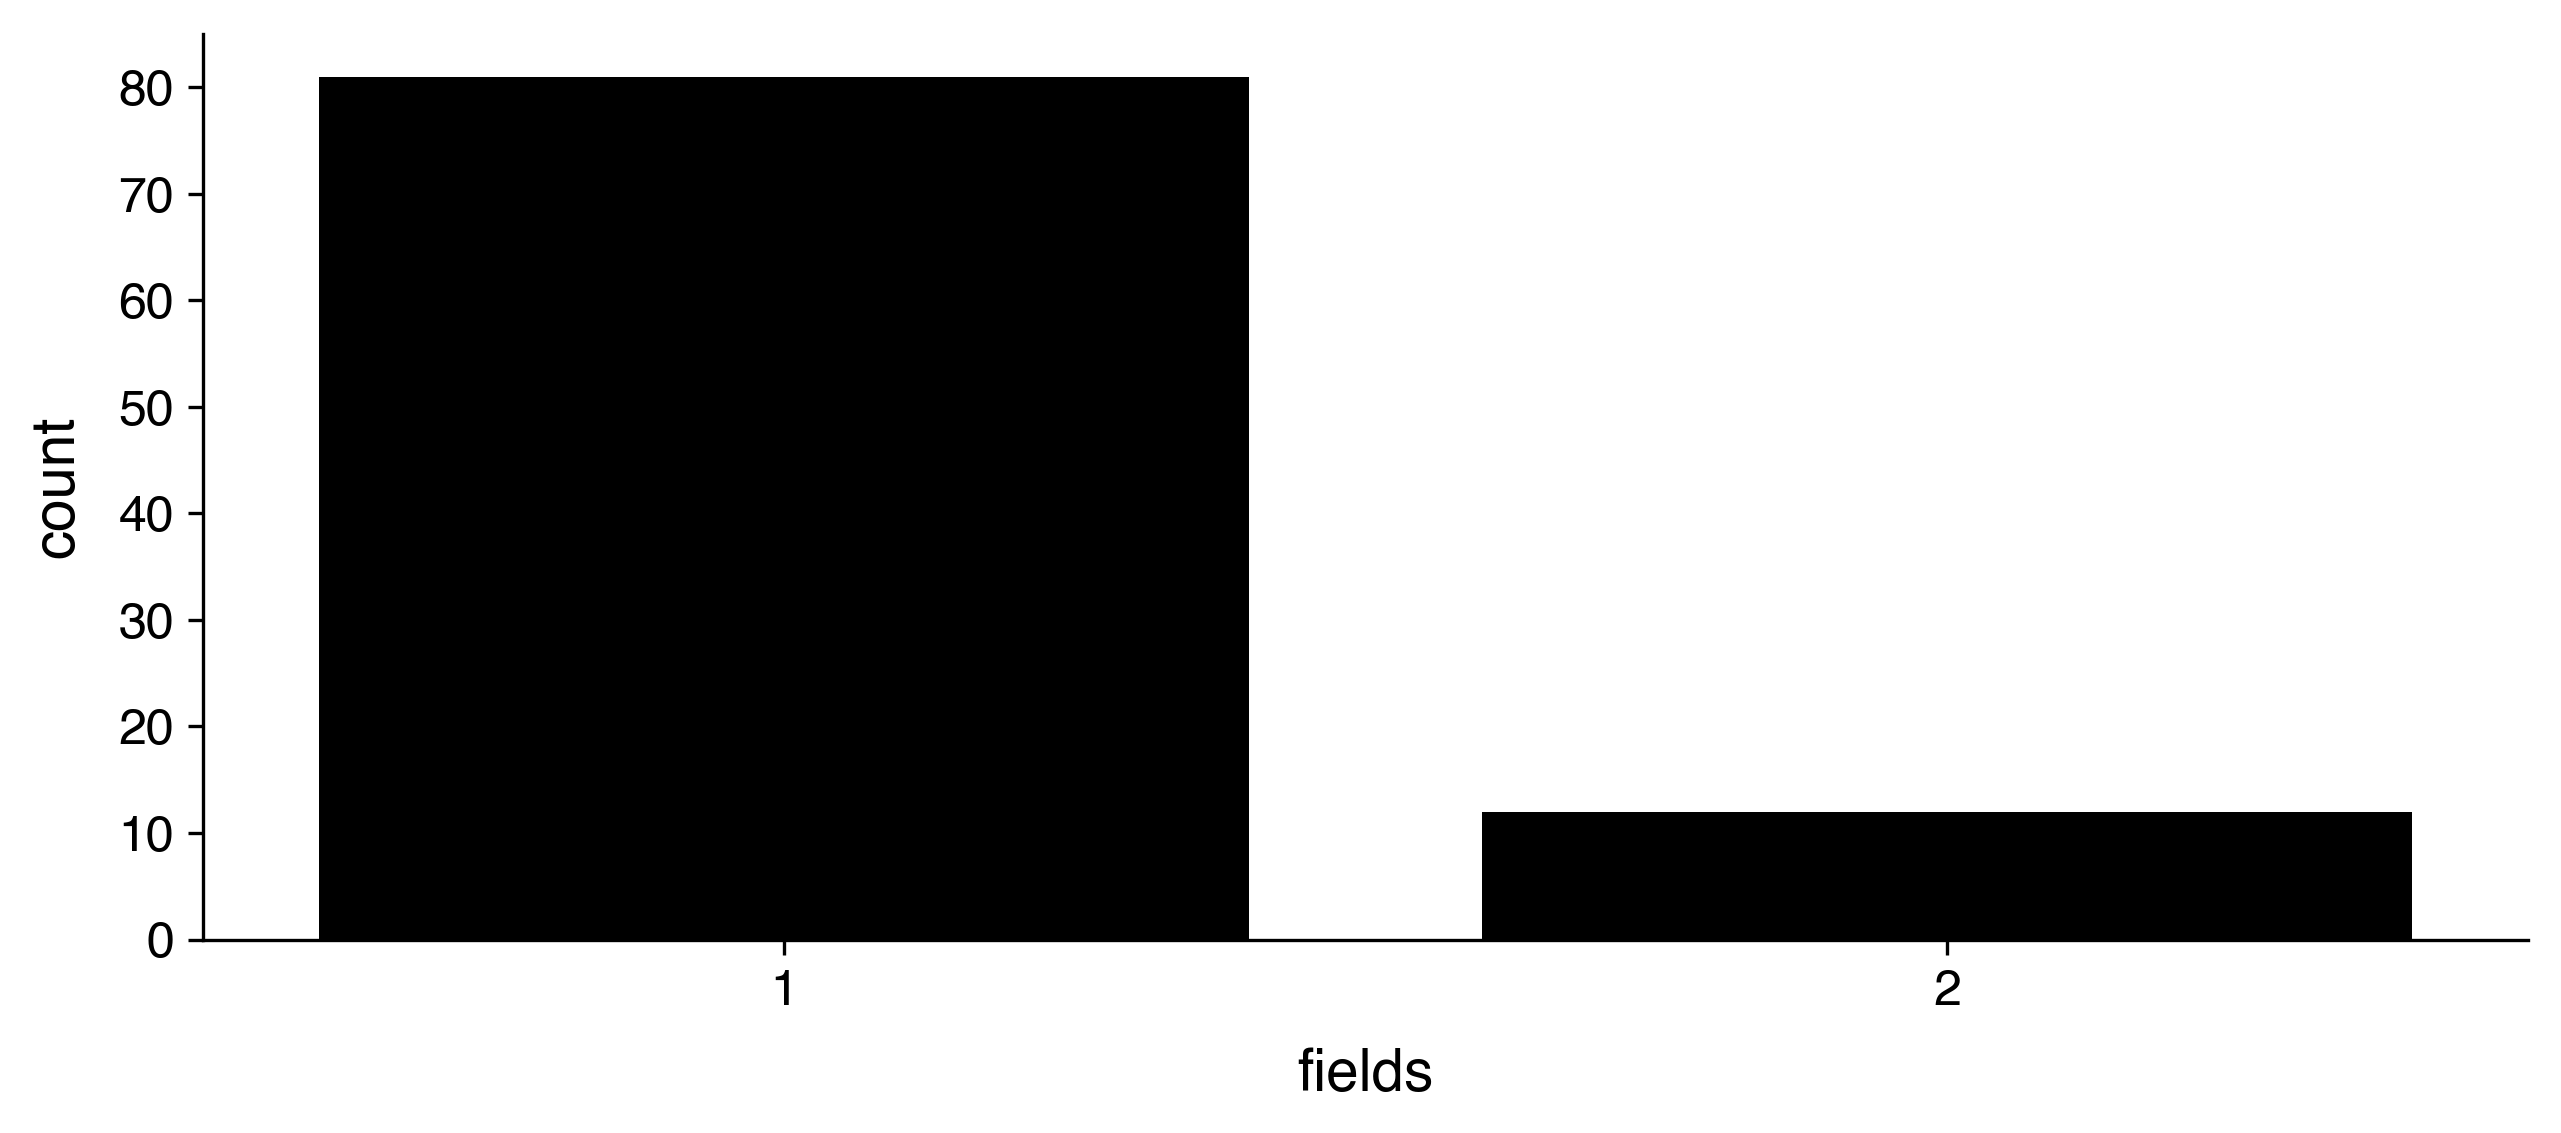

In [335]:
# How many positive time fields does each time cell have?
_df = aop.unique(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')").groupby('subj_sess_unit').size(),
                 sort=False).reset_index()
_df.columns = ['fields', 'count']
print('{} time fields/neuron'.format(mean_sem(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')").groupby('subj_sess_unit').size())))
print('{} time fields/neuron'.format(median_q(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')").groupby('subj_sess_unit').size())))
print('{} neurons have only 1 time field'
      .format(np.sum(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')").groupby('subj_sess_unit').size()==1)))
      
plt.close()
sns.barplot(x='fields', y='count', data=_df, color='k')

1.54 ± 0.62
1.50 (1.00, 2.00)


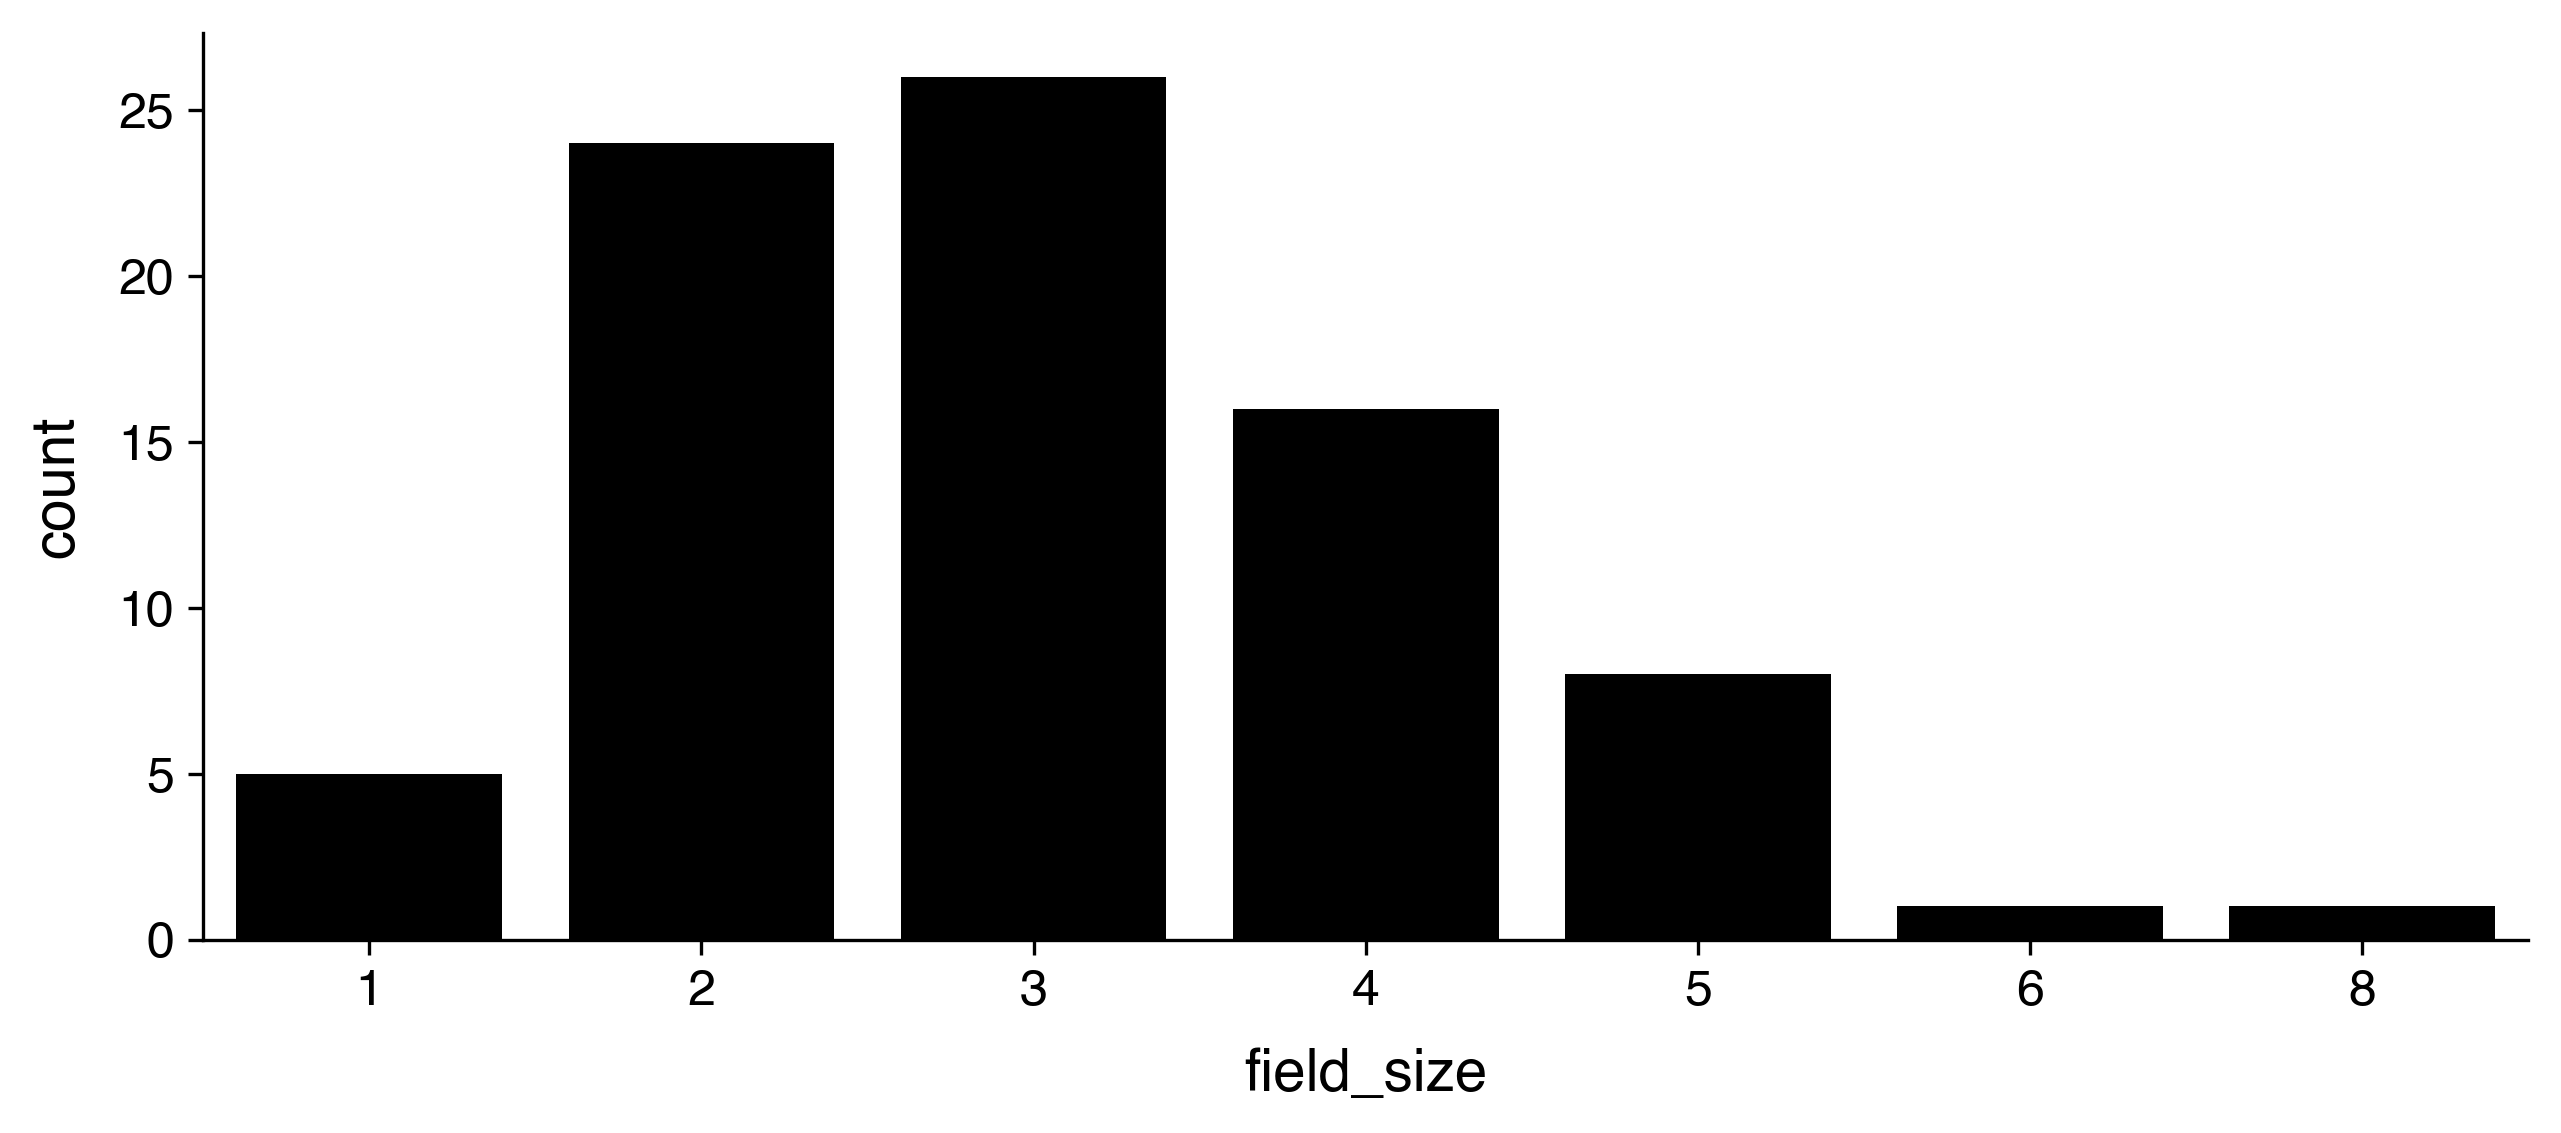

In [376]:
idx = np.where(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')").groupby('subj_sess_unit').size()==1)[0]
_neurons = time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')").groupby('subj_sess_unit').size().index[idx].tolist()
_df = (time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos') & (subj_sess_unit=={})".format(_neurons))
                  .groupby('field_size').size()
                  .reset_index()
                  .rename(columns={0: 'count'}))
plt.close()
sns.barplot(x='field_size', y='count', data=_df, color='k')

print(mean_sd(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos') & (subj_sess_unit=={})".format(_neurons))['field_size'] / 2))
print(median_q(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos') & (subj_sess_unit=={})".format(_neurons))['field_size'] / 2))

1.38 ± 0.07s field size
1.50 (1.00, 2.00)s field size


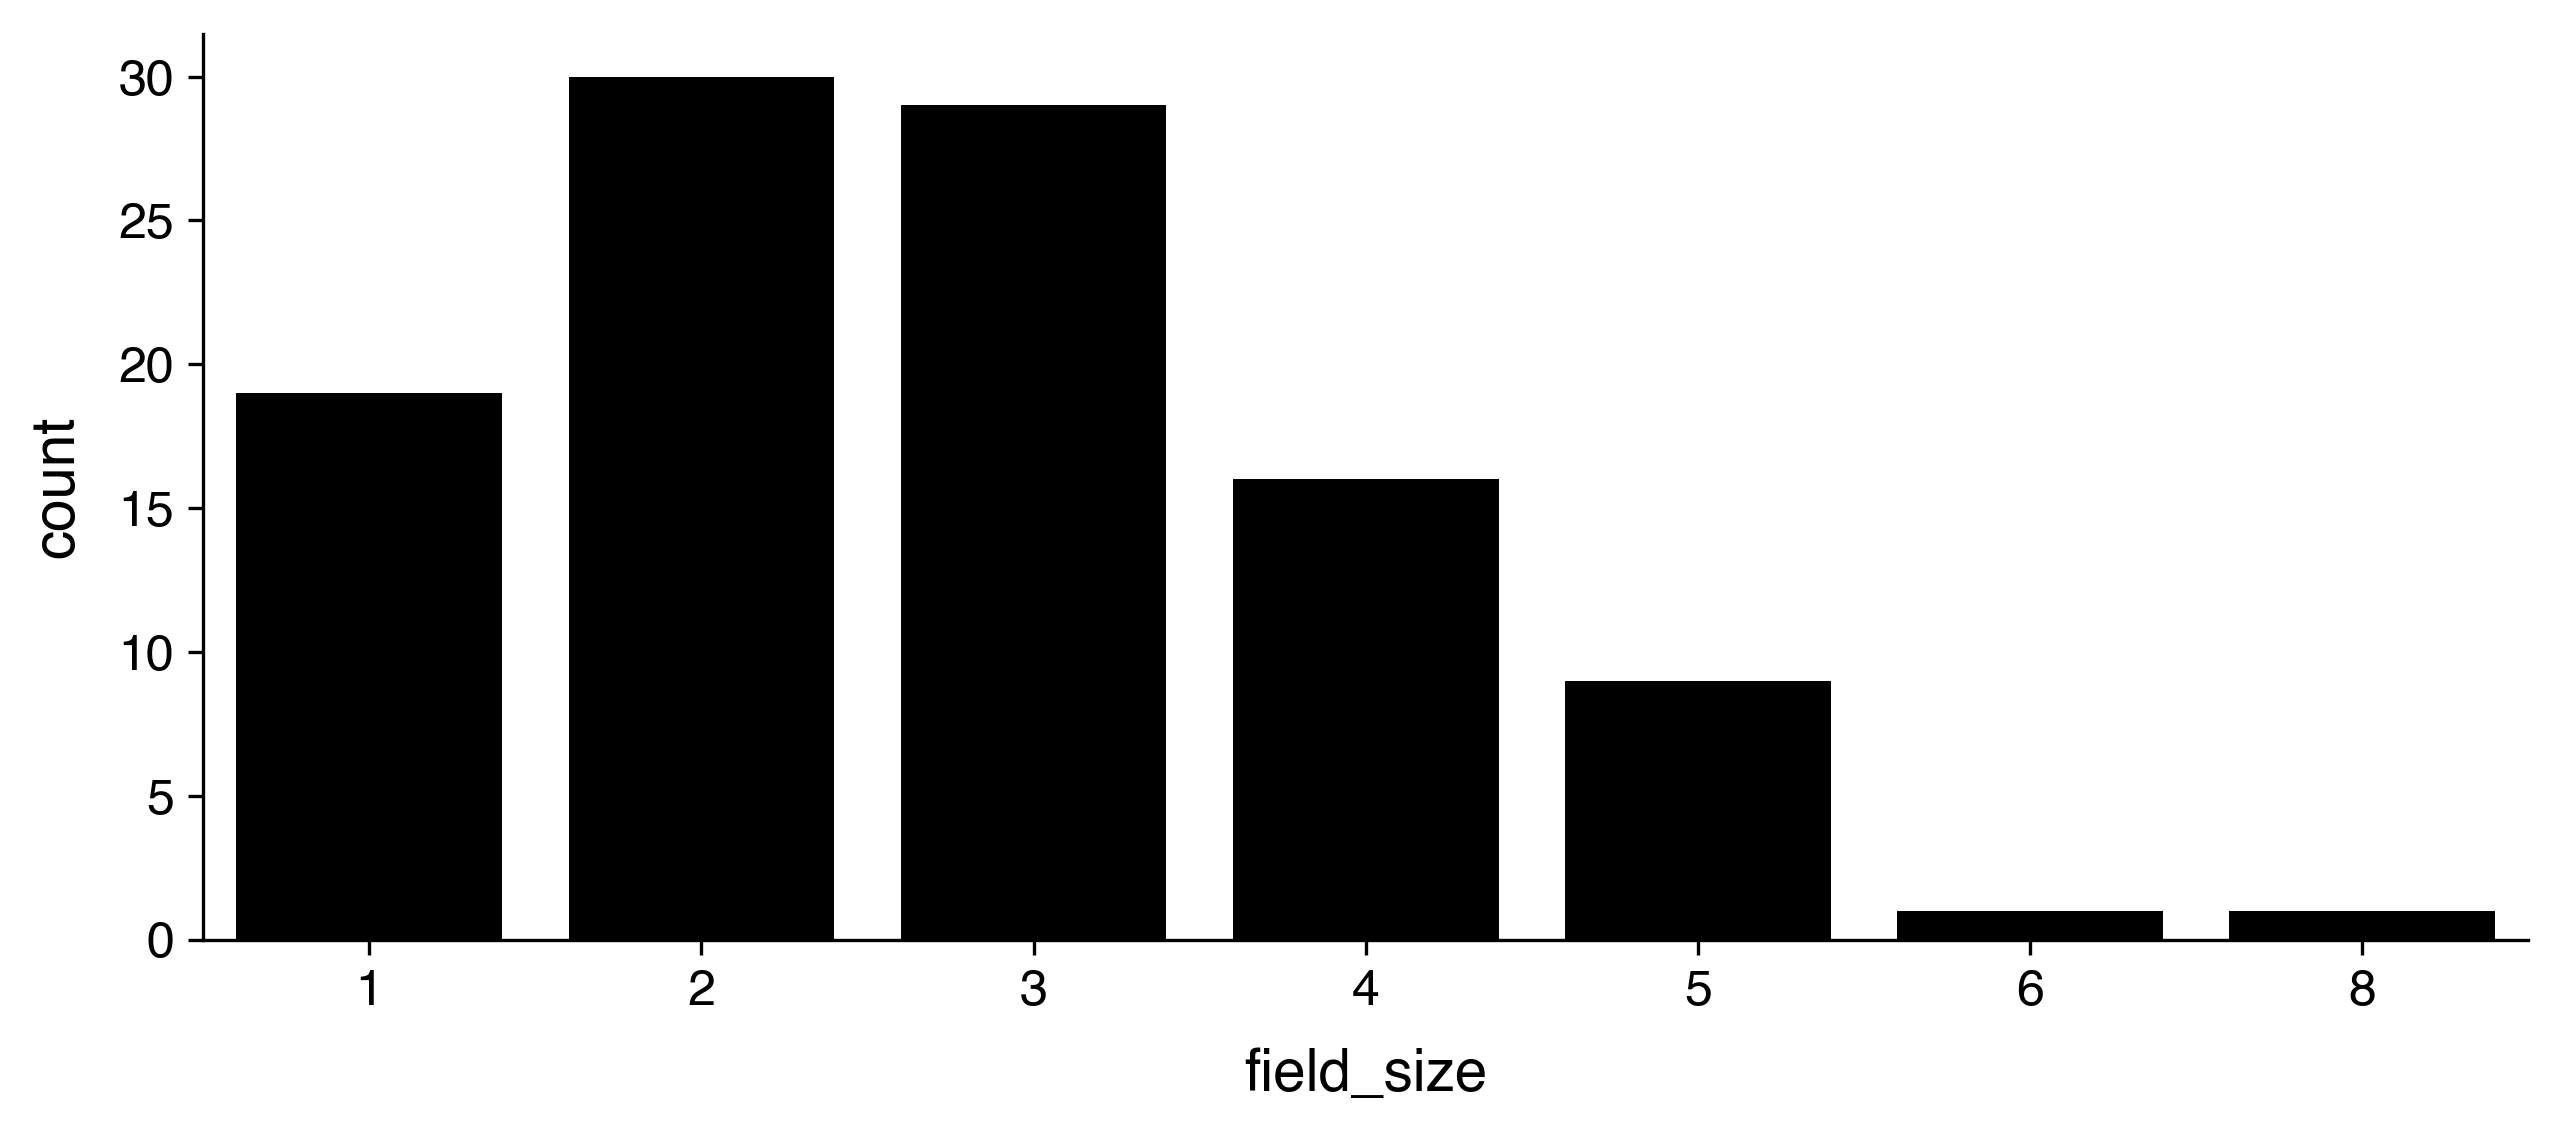

In [325]:
# Over what duration is each time field firing above the mean?
_df = time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')").groupby('field_size').size().reset_index()
_df.columns = ['field_size', 'count']
print('{}s field size'.format(mean_sem(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['field_size'] / 2)))
print('{}s field size'.format(median_q(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['field_size'] / 2)))

plt.close()
sns.barplot(x='field_size', y='count', data=_df, color='k')

7.05 ± 0.68 peak firing index
4.00 (1.00, 14.00) peak firing index


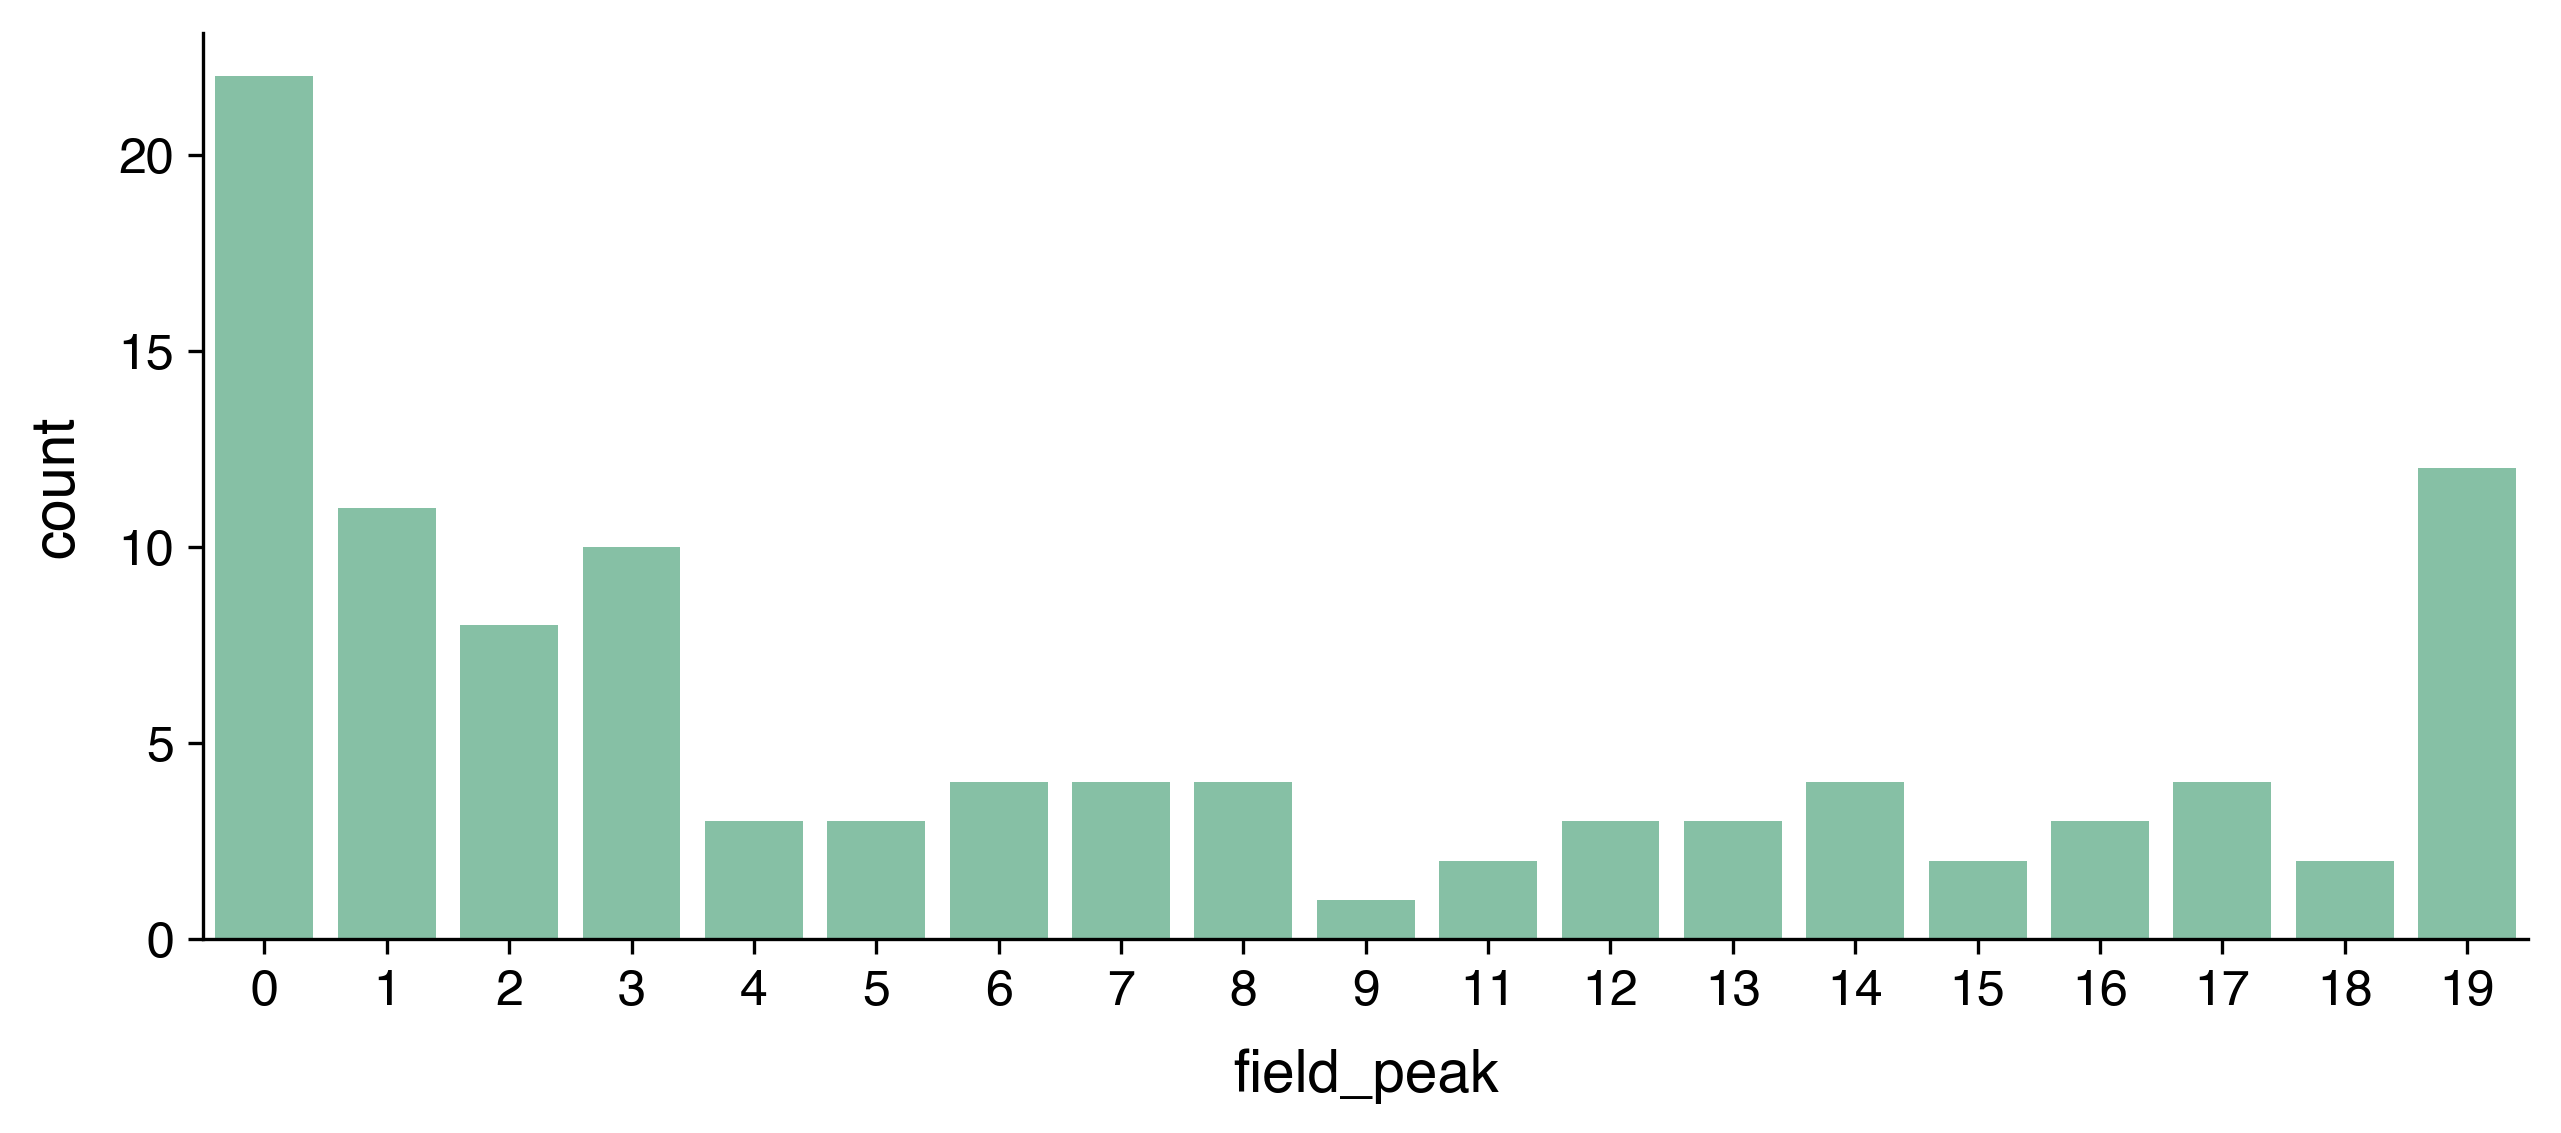

In [311]:
_df = time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')").groupby('field_peak').size().reset_index()
_df.columns = ['field_peak', 'count']
print('{} peak firing index'.format(mean_sem(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['field_peak'])))
print('{} peak firing index'.format(median_q(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['field_peak'])))

plt.close()
sns.barplot(x='field_peak', y='count', data=_df, color='#7ccaa5')

9.89 ± 0.67 peak firing index
11.00 (3.00, 16.00) peak firing index


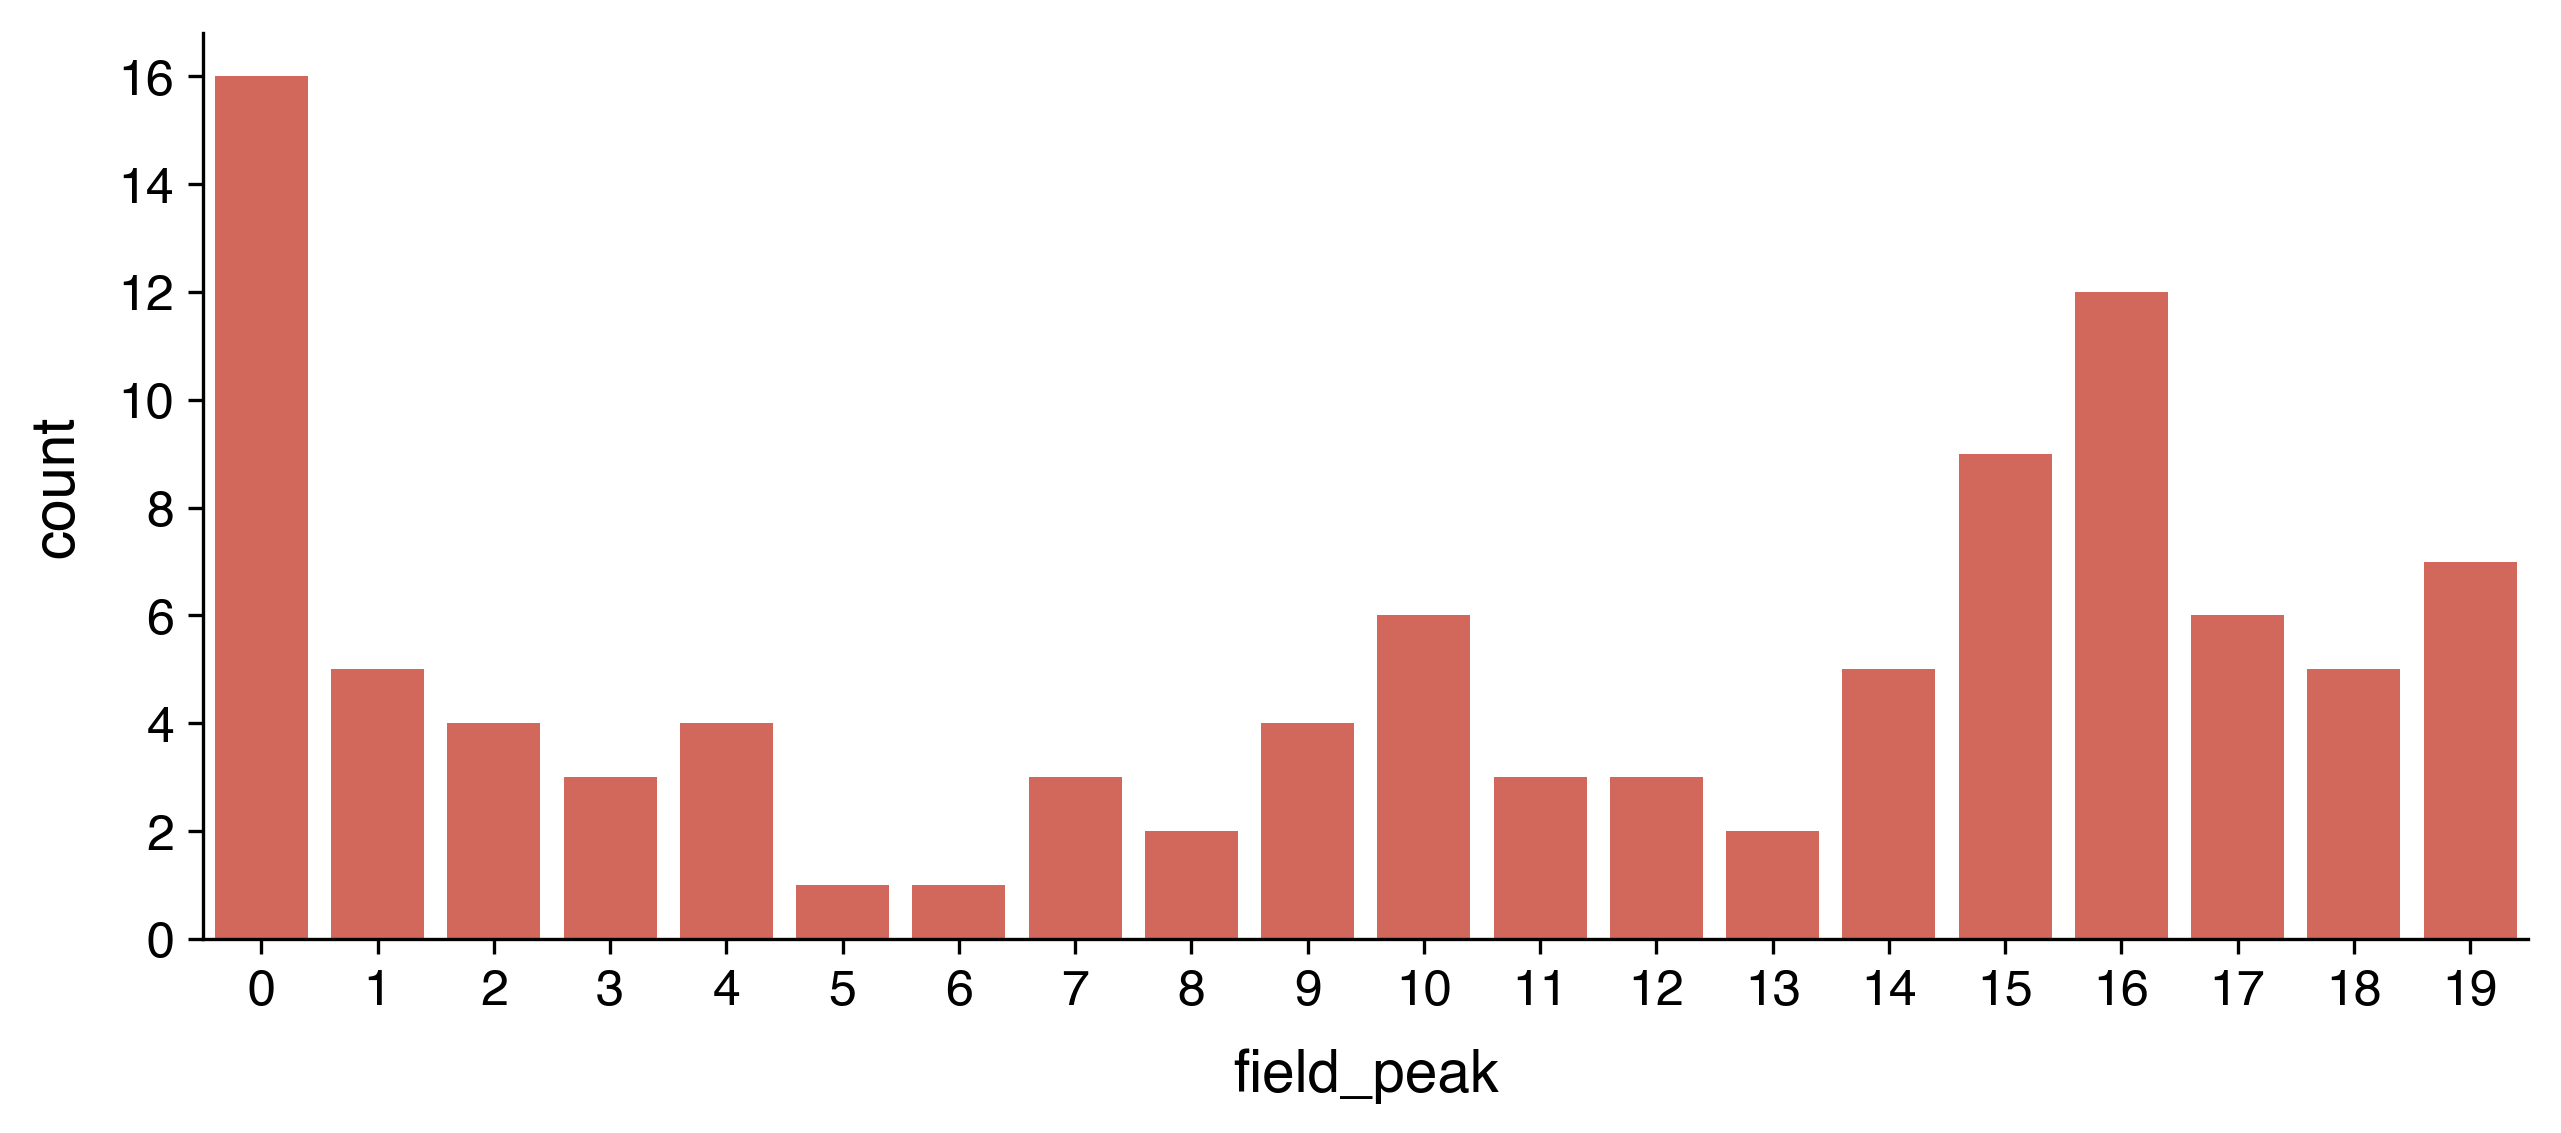

In [312]:
_df = time_fields.query("(gameState=='Delay1Delay2') & (field_type=='neg')").groupby('field_peak').size().reset_index()
_df.columns = ['field_peak', 'count']
print('{} peak firing index'.format(mean_sem(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='neg')")['field_peak'])))
print('{} peak firing index'.format(median_q(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='neg')")['field_peak'])))

plt.close()
sns.barplot(x='field_peak', y='count', data=_df, color='#e55749')

In [324]:
time_fields.head()

,subj_sess_unit,gameState,field_type,field_peak,peak_z,mean_z,field_size,field_idx
0,U518_ses0-32-1,Delay1,pos,0,5.733535,4.888654,2,"[0, 1]"
1,U518_ses0-32-1,Delay1,neg,10,-2.247025,-2.235923,2,"[10, 11]"
2,U518_ses0-32-1,Delay2,pos,0,2.646504,2.589658,2,"[0, 1]"
3,U518_ses0-32-1,Delay1Delay2,pos,0,5.839971,4.137489,3,"[0, 1, 2]"
4,U518_ses0-32-1,Delay1Delay2,neg,10,-2.096433,-2.096433,1,[10]


In [323]:
print('field_peak ~ field_size:', 
      stats.pearsonr(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['field_peak'],
                     time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['field_size']))
print('field_peak ~ peak_z:', 
      stats.pearsonr(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['field_peak'],
                     time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['peak_z']))
print('field_peak ~ mean_z:', 
      stats.pearsonr(time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['field_peak'],
                     time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')")['mean_z']))

formula = 'field_peak ~ field_size * mean_z'
mod = ols(formula, data=time_fields.query("(gameState=='Delay1Delay2') & (field_type=='pos')"))
fit = mod.fit()
print(fit.summary())

field_peak ~ field_size: (-0.1962858121704697, 0.04476865581492834)
field_peak ~ peak_z: (-0.46498023392149546, 5.814554834845358e-07)
field_peak ~ mean_z: (-0.4462415053848261, 1.8322975330496747e-06)
                            OLS Regression Results                            
Dep. Variable:             field_peak   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     8.804
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           3.06e-05
Time:                        14:08:28   Log-Likelihood:                -340.00
No. Observations:                 105   AIC:                             688.0
Df Residuals:                     101   BIC:                             698.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
        

In [39]:
timebin = 9
_params = ols_weights.set_index('level')['weight']

delay1_spikes = event_spikes.get_spike_mat(neuron, 'Delay1', column='time_step').values.astype(float)
delay2_spikes = event_spikes.get_spike_mat(neuron, 'Delay2', column='time_step').values.astype(float)
print(((delay1_spikes + delay2_spikes) / 2).mean(),
        delay1_spikes.mean(),
        delay2_spikes.mean())
print(_params['icpt'],
      _params['icpt'] + _params[Xycols['gameState'][0]],
      _params['icpt'] - _params[Xycols['gameState'][0]])
print('Delay1, timebin {}:'.format(timebin+1), delay1_spikes[:, timebin].mean())
print('Delay2, timebin {}:'.format(timebin+1), delay2_spikes[:, timebin].mean())
print('Delay1, timebin {}:'.format(timebin+1),
      _params['icpt'] + _params['gameState_Delay1'] + _params['time_{}'.format(timebin+1)] + _params['gameState_Delay1:time_{}'.format(timebin+1)])
print('Delay1, timebin {}:'.format(timebin+1), 
      _params['icpt'] - _params['gameState_Delay1'] + _params['time_{}'.format(timebin+1)] - _params['gameState_Delay1:time_{}'.format(timebin+1)])

5.588888888888889 5.477777777777778 5.7
5.588888888888884 5.477777777777769 5.699999999999999
Delay1, timebin 10: 4.361111111111111
Delay2, timebin 10: 4.333333333333333
Delay1, timebin 10: 4.361111111111075
Delay1, timebin 10: 4.333333333333297


In [8]:
params = ols_mods['full'].fit().params
n_params = 0
for k, v in Xycols.items():
    print(k, len(v))
    if k != 'neuron':
        n_params += len(v)
print('{} parameters total'.format(n_params))

neuron 1
gameState 1
time 9
gameState:time 9
19 parameters total


In [9]:
for mod_name, mod in ols_mods.items():
    print(mod_name, mod.fit().llf)

full -1545.5886812749577
subgs -1571.4729995620737
subtime -1550.212090446514
subgs:time -1550.5510191779483
icpt -1580.3432573998148


In [10]:
delay1_spikes = event_spikes.get_spike_mat(neuron, 'Delay1', column='time_step').values.astype(float)
delay2_spikes = event_spikes.get_spike_mat(neuron, 'Delay2', column='time_step').values.astype(float)
print(((delay1_spikes + delay2_spikes) / 2).mean(),
        delay1_spikes.mean(),
        delay2_spikes.mean())
print(params['Intercept'],
      params['Intercept'] + params[Xycols['gameState'][0]],
      params['Intercept'] - params[Xycols['gameState'][0]])
print(delay1_spikes[:, 3].mean(),
      params['Intercept'] + params[Xycols['gameState'][0]] + params[Xycols['time'][3]] + params[Xycols['gameState:time'][3]])
print(delay2_spikes[:, 3].mean(),
      params['Intercept'] - params[Xycols['gameState'][0]] + params[Xycols['time'][3]] - params[Xycols['gameState:time'][3]])

0.6347222222222222 0.06944444444444445 1.2
0.6347222222222222 0.06944444444444331 1.200000000000001
0.05555555555555555 0.05555555555555436
2.0555555555555554 2.0555555555555567


In [13]:
{k:v for k, v in Xycols.items() if k!='neuron'}

{'gameState': ['gameState_Delay1'],
 'time': ['time_1',
  'time_2',
  'time_3',
  'time_4',
  'time_5',
  'time_6',
  'time_7',
  'time_8',
  'time_9'],
 'gameState:time': ['gameState_Delay1:time_1',
  'gameState_Delay1:time_2',
  'gameState_Delay1:time_3',
  'gameState_Delay1:time_4',
  'gameState_Delay1:time_5',
  'gameState_Delay1:time_6',
  'gameState_Delay1:time_7',
  'gameState_Delay1:time_8',
  'gameState_Delay1:time_9']}

In [203]:
for mod_name, mod in ols_mods.items():
    print(mod_name, mod.fit().llf)

full -1545.5886812749577
full_subgs -1571.4729995620737
full_subtime -1550.212090446514
full_subgsxtime -1550.5510191779483
icpt -1580.3432573998148


In [206]:
Xy['gameState_Delay1'].value_counts()

-1.0    360
 1.0    360
Name: gameState_Delay1, dtype: int64

In [212]:
ols_mods['full'].fit().params[Xycols['gameState_x_time']]

gameState_Delay1:time_1    0.329167
gameState_Delay1:time_2    0.120833
gameState_Delay1:time_3   -0.254167
gameState_Delay1:time_4   -0.434722
gameState_Delay1:time_5   -0.268056
gameState_Delay1:time_6    0.106944
gameState_Delay1:time_7   -0.115278
gameState_Delay1:time_8    0.231944
gameState_Delay1:time_9    0.023611
dtype: float64

In [204]:
print(ols_mods['full'].fit().summary())

                            OLS Regression Results                            
Dep. Variable:              Q('58-2')   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.734
Date:                Fri, 24 Sep 2021   Prob (F-statistic):           1.70e-07
Time:                        15:25:40   Log-Likelihood:                -1545.6
No. Observations:                 720   AIC:                             3131.
Df Residuals:                     700   BIC:                             3223.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [198]:
5.7303+0.8273+0.3606

6.9182

In [88]:
for mod, fit in mod_fits.items():
    print(mod, fit.fit().llf)

full -1688.8651814806412
full_subgs -1688.8651814806412
full_subtime -1688.8651814806412
full_subintn -1694.4473266052596
red -1727.895493103502


In [165]:
def get_ols_time_formulas(neuron, full_mod):
    """Define model formulas for single-unit to behavior comparisons.
    
    Parameters
    ----------
    neuron : str
        e.g. '5-2' would be channel 5, unit 2
    """
    # Get the expanded predictor matrix of deviation-coded parameters,
    # and add on the dependent column.
    Xy = pd.concat((pd.Series(full_mod.endog, name=neuron),
                    pd.DataFrame(full_mod.exog, columns=full_mod.exog_names)),
                   axis=1)
    Xy.drop(columns=['Intercept'], inplace=True)
    Xycols_old = od([('neuron', [neuron]),
                     ('gameState', [col for col in Xy.columns if np.all([('gameState' in col),
                                                                         (':' not in col)])]),
                     ('time', [col for col in Xy.columns if np.all([('time_step' in col),
                                                                    (':' not in col)])]),
                     ('gameState_x_time', [col for col in Xy.columns if np.all([('time' in col),
                                                                                ('gameState' in col),
                                                                                (':' in col)])])])
    Xycols_new = od([('neuron', [neuron]),
                     ('gameState', str_replace(Xcols['gameState'], {'C(gameState, Sum)[S.': 'gameState_',
                                                                    ']': ''})),
                     ('time', str_replace(Xcols['time'], {'C(time_step, Sum)[S.': 'time_',
                                                          ']': ''})),
                     ('gameState_x_time', str_replace(Xcols['gameState_x_time'], {'C(gameState, Sum)[S.': 'gameState_',
                                                                                  'C(time_step, Sum)[S.': 'time_',
                                                                                  ']': ''}))])
    for col_type in Xycols_old:
        Xy.rename(columns=pd.Series(index=Xycols_old[col_type], data=Xycols_new[col_type]).to_dict(), inplace=True)
    Xycols = Xycols_new
    
    # Define formulas.
    formulas = od([])
    formulas['full']             = "Q('{}') ~ 1 + {} + {} + {}".format(neuron, ' + '.join(Xycols['gameState']), ' + '.join(Xycols['time']), ' + '.join(Xycols['gameState_x_time']))
    formulas['subgs']       = "Q('{}') ~ 1      + {} + {}".format(neuron,                                  ' + '.join(Xycols['time']), ' + '.join(Xycols['gameState_x_time']))
    formulas['subtime']     = "Q('{}') ~ 1 + {}      + {}".format(neuron, ' + '.join(Xycols['gameState']),                             ' + '.join(Xycols['gameState_x_time']))
    formulas['subgsxtime']  = "Q('{}') ~ 1 + {} + {}     ".format(neuron, ' + '.join(Xycols['gameState']), ' + '.join(Xycols['time'])                                        )
    
    return Xy, Xycols, formulas

In [166]:
Xy, Xycols, formulas = get_ols_time_formulas(neuron, mod_fits['full'])

In [170]:
# Fit the model.
mod_fits = od([])
for mod, formula in formulas.items():
    mod_fits[mod] = ols(formula, data=Xy)#.fit()

In [171]:
for mod, fit in mod_fits.items():
    print(mod, fit.fit().llf)

full -1688.8651814806412
full_subgs -1711.1951717816542
full_subtime -1701.3266537191166
full_subgsxtime -1694.4473266052596


In [172]:
mod_fits['full'].fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('21-1')   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.229
Date:                Fri, 24 Sep 2021   Prob (F-statistic):           6.88e-09
Time:                        14:44:45   Log-Likelihood:                -1688.9
No. Observations:                 660   AIC:                             3418.
Df Residuals:                     640   BIC:                             3508.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   5.7303      0.124     46.365      0.000       5.488       5.973
gameState_Delay1            0.8273      0.124      6.694      0.000       0.585       1.070
time_1                      0.3606      0.371      0.973      0.331      -0.367       1.089
time_2                     -0.3061      0.371     -0.825      0.409      -1.034       0.422
time_3                     -1.0030      0.371     -2.705      0.007      -1.731      -0.275
time_4                     -0.1848      0.371     -0.499      0.618      -0.913       0.543
time_5                     -0.2909      0.371     -0.785      0.433      -1.019       0.437
time_6                     -0.2303      0.371     -0.621      0.535      -0.958       0.498
time_7                     -0.4576      0.371     -1.234      0.218      -1.186       0.270
time_8                      0.0576      0.371      0.155      0.877      -0.670       0.786
time_9                      0.8909      0.371      2.403      0.017       0.163       1.619
gameState_Delay1:time_1    -0.4636      0.371     -1.250      0.212      -1.192       0.264
gameState_Delay1:time_2     0.1727      0.371      0.466      0.641      -0.555       0.901
gameState_Delay1:time_3    -0.1606      0.371     -0.433      0.665      -0.889       0.567
gameState_Delay1:time_4     0.0818      0.371      0.221      0.825      -0.646       0.810
gameState_Delay1:time_5    -0.5091      0.371     -1.373      0.170      -1.237       0.219
gameState_Delay1:time_6     0.0061      0.371      0.016      0.987      -0.722       0.734
gameState_Delay1:time_7    -0.4333      0.371     -1.169      0.243      -1.161       0.295
gameState_Delay1:time_8     0.0212      0.371      0.057      0.954      -0.707       0.749
gameState_Delay1:time_9     0.8848      0.371      2.387      0.017       0.157       1.613
==============================================================================
Omnibus:                       98.461   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.484
Skew:                           0.879   Prob(JB):                     3.20e-41
Kurtosis:                       4.921   Cond. No.                         3.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
mod_fits['full'].fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('21-1')   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.229
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           6.88e-09
Time:                        16:51:34   Log-Likelihood:                -1688.9
No. Observations:                 660   AIC:                             3418.
Df Residuals:                     640   BIC:                             3508.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              5.7303      0.124     46.365      0.000       5.488       5.973
C(gameState, Sum)[S.Delay1]                            0.8273      0.124      6.694      0.000       0.585       1.070
C(time_step, Sum)[S.1]                                 0.3606      0.371      0.973      0.331      -0.367       1.089
C(time_step, Sum)[S.2]                                -0.3061      0.371     -0.825      0.409      -1.034       0.422
C(time_step, Sum)[S.3]                                -1.0030      0.371     -2.705      0.007      -1.731      -0.275
C(time_step, Sum)[S.4]                                -0.1848      0.371     -0.499      0.618      -0.913       0.543
C(time_step, Sum)[S.5]                                -0.2909      0.371     -0.785      0.433      -1.019       0.437
C(time_step, Sum)[S.6]                                -0.2303      0.371     -0.621      0.535      -0.958       0.498
C(time_step, Sum)[S.7]                                -0.4576      0.371     -1.234      0.218      -1.186       0.270
C(time_step, Sum)[S.8]                                 0.0576      0.371      0.155      0.877      -0.670       0.786
C(time_step, Sum)[S.9]                                 0.8909      0.371      2.403      0.017       0.163       1.619
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.1]    -0.4636      0.371     -1.250      0.212      -1.192       0.264
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.2]     0.1727      0.371      0.466      0.641      -0.555       0.901
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.3]    -0.1606      0.371     -0.433      0.665      -0.889       0.567
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.4]     0.0818      0.371      0.221      0.825      -0.646       0.810
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.5]    -0.5091      0.371     -1.373      0.170      -1.237       0.219
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.6]     0.0061      0.371      0.016      0.987      -0.722       0.734
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.7]    -0.4333      0.371     -1.169      0.243      -1.161       0.295
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.8]     0.0212      0.371      0.057      0.954      -0.707       0.749
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.9]     0.8848      0.371      2.387      0.017       0.157       1.613
==============================================================================
Omnibus:                       98.461   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.484
Skew:                           0.879   Prob(JB):                     3.20e-41
Kurtosis:                     

In [117]:
5.7303 + 0.8273, 5.7303 - 0.8273

(6.5576, 4.903)

In [110]:
delay1_spikes = event_spikes.get_spike_mat(neuron, 'Delay1', column='time_step').values.astype(float)
delay2_spikes = event_spikes.get_spike_mat(neuron, 'Delay2', column='time_step').values.astype(float)
delay1_spikes.mean(), delay2_spikes.mean(), ((delay1_spikes + delay2_spikes) / 2).mean()

(6.557575757575758, 4.903030303030303, 5.7303030303030305)

In [114]:
5.7303 + 0.8273 + 0.3606 + -0.4636, delay1_spikes[:, 0].mean()

(6.454599999999999, 6.454545454545454)

In [108]:
np.mean((delay1_spikes + delay2_spikes) / 2)

5.7303030303030305

In [79]:
delay1_spikes[1].mean() / 2

3.227272727272727

In [101]:
#event_spikes.get_spike_mat(neuron, 'Delay1', column='time_step').values.astype(float)

In [30]:
mod_fits['full'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('21-1')   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     5.060
Date:                Thu, 23 Sep 2021   Prob (F-statistic):           8.41e-12
Time:                        16:28:46   Log-Likelihood:                -2812.1
No. Observations:                1320   AIC:                             5664.
Df Residuals:                    1300   BIC:                             5768.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              2.8652      0.056     50.715      0.000       2.754       2.976
C(gameState, Sum)[S.Delay1]                            0.4136      0.056      7.322      0.000       0.303       0.524
C(time_step, Sum)[S.1]                                 0.1803      0.169      1.064      0.288      -0.152       0.513
C(time_step, Sum)[S.2]                                -0.1530      0.169     -0.903      0.367      -0.486       0.179
C(time_step, Sum)[S.3]                                -0.5015      0.169     -2.959      0.003      -0.834      -0.169
C(time_step, Sum)[S.4]                                -0.0924      0.169     -0.545      0.586      -0.425       0.240
C(time_step, Sum)[S.5]                                -0.1455      0.169     -0.858      0.391      -0.478       0.187
C(time_step, Sum)[S.6]                                -0.1152      0.169     -0.679      0.497      -0.448       0.217
C(time_step, Sum)[S.7]                                -0.2288      0.169     -1.350      0.177      -0.561       0.104
C(time_step, Sum)[S.8]                                 0.0288      0.169      0.170      0.865      -0.304       0.361
C(time_step, Sum)[S.9]                                 0.4455      0.169      2.628      0.009       0.113       0.778
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.1]    -0.2318      0.169     -1.368      0.172      -0.564       0.101
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.2]     0.0864      0.169      0.510      0.610      -0.246       0.419
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.3]    -0.0803      0.169     -0.474      0.636      -0.413       0.252
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.4]     0.0409      0.169      0.241      0.809      -0.292       0.373
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.5]    -0.2545      0.169     -1.502      0.133      -0.587       0.078
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.6]     0.0030      0.169      0.018      0.986      -0.329       0.336
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.7]    -0.2167      0.169     -1.278      0.201      -0.549       0.116
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.8]     0.0106      0.169      0.063      0.950      -0.322       0.343
C(gameState, Sum)[S.Delay1]:C(time_step, Sum)[S.9]     0.4424      0.169      2.610      0.009       0.110       0.775
==============================================================================
Omnibus:                      239.889   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.349
Skew:                           1.041   Prob(JB):                    3.03e-110
Kurtosis:                     

In [18]:
mod_fits['red'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('21-1')   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 23 Sep 2021   Prob (F-statistic):                nan
Time:                        16:25:59   Log-Likelihood:                -2859.2
No. Observations:                1320   AIC:                             5720.
Df Residuals:                    1319   BIC:                             5726.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8652      0.058     49.294      0.000       2.751       2.979
==============================================================================
Omnibus:                      297.845   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              695.695
Skew:                           1.228   Prob(JB):                    8.54e-152
Kurtosis:                       5.573   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
1

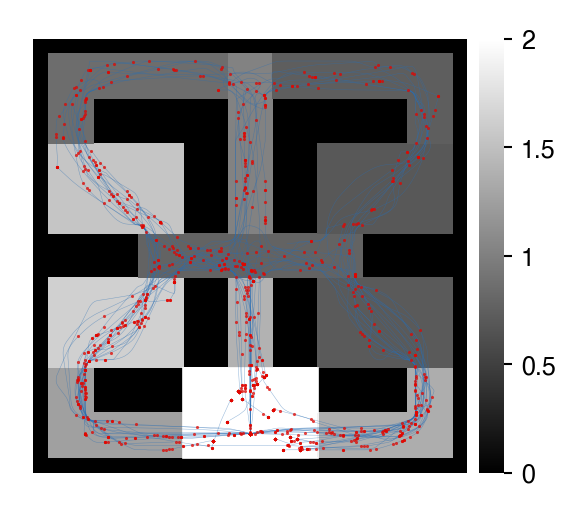

In [98]:
neuron = '8-2'
dpi = 300
font = {'tick': 6, 'label': 7, 'fig': 9}
base_color = 'w'
game_states = ['Encoding']
spikes_when_moving = False

for game_state in game_states:    
    fig, ax = time_cell_plots.plot_firing_maze(subj_sess, 
                                               neuron, 
                                               game_state, 
                                               font=font, 
                                               base_color=base_color,
                                               only_show_spikes_when_moving=spikes_when_moving,
                                               nav_lw=0.12,
                                               nav_color='#296eb4',
                                               nav_alpha=0.5,
                                               spike_marker='.',
                                               spike_fill_color='#e10600',
                                               spike_edge_color='#e10600',
                                               spike_alpha=0.75,
                                               spike_markersize=1.5,
                                               spike_mew=0,
                                               dpi=dpi)
    
fig.show()

In [236]:
def run_place_cells_parallel(subj_sess_neuron):
    import sys
    import os
    import os.path as op
    import pandas as pd
    sys.path.append('/home1/dscho/code/general')
    import data_io as dio
    sys.path.append('/home1/dscho/code/projects')
    from time_cells import time_bin_analysis
    sys.path.append('/home1/dscho/code/goldmine_replay')
    import place_cells
    
    save_output = True
    overwrite = False
    game_state = 'Encoding'
    nperm = 1000
    alpha = 0.05
    zthresh = 2
    data_dir = '/data7/goldmine'
    proj_dir = '/home1/dscho/projects/goldmine_replay'
    
    try:
        subj_sess, *neuron = subj_sess_neuron.split('-')
        neuron = '-'.join(neuron)

        # Load event_spikes.
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=data_dir)

        obs_weights = place_cells.get_ols_params_place(neuron, event_spikes, game_state=game_state)
        null_weights = pd.concat([place_cells.get_ols_params_place(neuron, event_spikes, game_state=game_state, circshift_frs=True)
                                  for iPerm in range(nperm)])
        place_fits = place_cells.get_ols_sig_place(obs_weights, null_weights, alpha=alpha, zthresh=zthresh)

        if save_output:
            filename = op.join(proj_dir, 'ols_place_cells', '{}-{}.pkl'.format(place_fits.iloc[0]['subj_sess_unit'], place_fits.iloc[0]['gameState']))
            if overwrite or not op.exists(filename):
                dio.save_pickle(place_fits, filename, verbose=False)    
    except:
        err = sys.exc_info()
        errf = '/home1/dscho/logs/TryExceptError-run_place_cells_parallel-{}'.format(subj_sess_neuron)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')

In [238]:
# Get neurons to process.
fpath = op.join(proj_dir, 'ols_place_cells', '{}-Encoding.pkl')
pop_spikes = pop_decoding.load_pop_spikes()
neurons = [neuron for neuron in pop_spikes.neurons if not op.exists(fpath.format(neuron))]
print('{} neurons to process'.format(len(neurons)))

# Parallel processing
n_ops = len(neurons)
print('Running code for {} operations.\n'.format(n_ops))
with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=np.min((n_ops, 200)), cores_per_job=1) as view:
    output = view.map(run_place_cells_parallel, neurons)

454 neurons to process
Running code for 454 operations.

26 Engines running
Sending a shutdown signal to the controller and engines.


In [17]:
# Load place cells.
files = glob(op.join(proj_dir, 'ols_place_cells', '*-Encoding.pkl'))
place_fits = pd.concat([dio.open_pickle(f) for f in files]).reset_index(drop=True)

# Add columns.
place_fits.insert(0, 'subj', place_fits['subj_sess_unit'].apply(lambda x: x.split('-')[0].split('_')[0]))
place_fits.insert(1, 'subj_sess', place_fits['subj_sess_unit'].apply(lambda x: x.split('-')[0]))
place_fits.insert(2, 'neuron', place_fits['subj_sess_unit'].apply(lambda x: '-'.join(x.split('-')[1:])))
place_fits.insert(3, 'hemroi', place_fits.apply(lambda x: spike_preproc.roi_lookup(x['subj_sess'], x['neuron'].split('-')[0]), axis=1))
roi_map = spike_preproc.roi_mapping(5)
place_fits.insert(4, 'roi_gen', place_fits['hemroi'].apply(lambda x: roi_map[x[1:]]))
place_fits.insert(place_fits.columns.tolist().index('sig')+1, 'sig_pos', (place_fits['sig'] == True) & (place_fits['n_place_fields'] > 0))

# Save indices to all place cells and place cells with a place field outside the base, respectively.
place_all_idx = place_fits.query("(sig_pos==True)").index.values
place_mine_idx = place_all_idx[np.where(place_fits.query("(sig_pos==True)")['place_fields']
                                                  .apply(lambda x: len([place for place in x if place!='Base'])>0))[0]]

print('place_fits:', place_fits.shape)

place_fits: (457, 44)


In [47]:
n_cells = place_fits['subj_sess_unit'].size
n_place_cells = len(place_fits.query("(sig==True)"))
n_pos_place_cells = len(place_fits.query("(sig==True) & (n_place_fields>0)"))

print('{}/{} ({:.1%}) cells are significant for place'.format(n_place_cells, n_cells, n_place_cells/n_cells))
print('{}/{} ({:.1%}) significant cells have 1+ place fields'.format(n_pos_place_cells, n_place_cells, n_pos_place_cells/n_place_cells))
display(place_fits.query("(sig==True)").groupby('n_place_fields').agg({'subj_sess_unit': len}).rename(columns={'subj_sess_unit': 'n'}))

152/457 (33.3%) cells are significant for place
124/152 (81.6%) significant cells have 1+ place fields


,n
n_place_fields,
0,28
1,91
2,28
3,5


In [48]:
def sum_pct(x):
    _sum = np.sum(x)
    _n = len(x)
    return '{}/{} ({:.1%})'.format(_sum, _n, _sum/_n)
    
display(place_fits.groupby('roi_gen').agg({'sig_pos': sum_pct}))
display(place_fits.groupby('subj').agg({'sig_pos': sum_pct}))

,sig_pos
roi_gen,
Frontal,15/69 (21.7%)
Hippocampus,24/109 (22.0%)
MTL,64/204 (31.4%)
Temporal,21/75 (28.0%)


,sig_pos
subj,
U518,21/66 (31.8%)
U521,15/24 (62.5%)
U526,10/25 (40.0%)
U527,5/33 (15.2%)
U530,19/102 (18.6%)
U532,21/65 (32.3%)
U536,20/73 (27.4%)
U537,5/13 (38.5%)
U539,1/13 (7.7%)


In [55]:
place_fields = aop.unique(np.concatenate(place_fits.query("(sig_pos==True)")['place_fields'].tolist()))

print('All place cells:')
print('{} place fields across {} place cells'.format(place_fields.sum(), len(place_fits.query("(sig_pos==True)"))), end='\n'*2)

print('Subset of place cells with a place cell outside the mine:')
print('{} place fields across {} place cells'.format(place_fields.sum(), len(place_fits.loc[place_mine_idx])))

display(pd.concat([place_fields, place_fields / place_fields.sum()], axis=1).rename(columns={0: 'n', 1: 'prop'}))

All place cells:
162 place fields across 124 place cells

Subset of place cells with a place cell outside the mine:
162 place fields across 87 place cells


,n,prop
Base,49,0.302469
C_Hall,17,0.104938
SE_Hall,16,0.098765
SW_Room,11,0.067901
N_Passage,11,0.067901
NW_Room,11,0.067901
NE_Room,10,0.061728
S_Passage,9,0.055556
SW_Hall,9,0.055556
NW_Hall,8,0.049383


In [104]:
full = 'full'
red = 'subplace'

output.query("(mod=='{}')").pivot(index=['subj_sess_unit', 'gameState', 'mod', 'llf'], columns=['level'], values=['weight'])

weight             \
level                                                  icpt place-Base   
subj_sess_unit gameState mod  llf                                        
U532_ses0-8-2  Encoding  full -3228.3126106516293  1.182911   0.850759   

                                                                              \
level                                             place-C_Hall place-NE_Hall   
subj_sess_unit gameState mod  llf                                              
U532_ses0-8-2  Encoding  full -3228.3126106516293    -0.391244     -0.435247   

                                                                               \
level                                             place-NE_Room place-NW_Hall   
subj_sess_unit gameState mod  llf                                               
U532_ses0-8-2  Encoding  full -3228.3126106516293     -0.477029     -0.316244   

                                                                 \
level                                             place-NW_Room   
subj_sess_unit gameState mod  llf                                 
U532_ses0-8-2  Encoding  full -3228.3126106516293      0.383354   

                                                                   \
level                                             place-N_Passage   
subj_sess_unit gameState mod  llf                                   
U532_ses0-8-2  Encoding  full -3228.3126106516293       -0.142911   

                                                                               \
level                                             place-SE_Hall place-SE_Room   
subj_sess_unit gameState mod  llf                                               
U532_ses0-8-2  Encoding  full -3228.3126106516293      0.192089      -0.46593   

                                                                               \
level                                             place-SW_Hall place-SW_Room   
subj_sess_unit gameState mod  llf                                               
U532_ses0-8-2  Encoding  full -3228.3126106516293      0.089816      0.475209   

                                                                   
level                                             place-S_Passage  
subj_sess_unit gameState mod  llf                                  
U532_ses0-8-2  Encoding  full -3228.3126106516293        0.237379

In [81]:
print(mod_fits['subplace'].summary())

                            OLS Regression Results                            
Dep. Variable:               Q('8-2')   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 21 Sep 2021   Prob (F-statistic):                nan
Time:                        16:08:13   Log-Likelihood:                -3271.0
No. Observations:                1980   AIC:                             6544.
Df Residuals:                    1979   BIC:                             6550.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6813      0.028     24.007      0.0

In [53]:
print(mod_fits['subplace'].summary())

                            OLS Regression Results                            
Dep. Variable:               Q('8-2')   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     9.049
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           7.74e-31
Time:                        15:50:41   Log-Likelihood:                -6552.9
No. Observations:                3960   AIC:                         1.315e+04
Df Residuals:                    3936   BIC:                         1.330e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [40]:
print(mod_fits['full'].summary())

                            OLS Regression Results                            
Dep. Variable:               Q('8-2')   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     9.049
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           7.74e-31
Time:                        15:41:46   Log-Likelihood:                -6552.9
No. Observations:                3960   AIC:                         1.315e+04
Df Residuals:                    3936   BIC:                         1.330e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------